# Команда AIV. DataWagon. Кейс 2, "Чек-ап вагона".

# Обоснование принятых решений и выводы

**Для погружения в тематику кейса и более аккуратной работы с предоставленными наборами данных мы провели небольшой анализ профильной литературы** (диссертации аспирантов МИИТ, журнал "Вагоны и вагонное хозяйство" ГК ИЦВС). 

Авторами выделяются следующие факторы, влияющие на срок службы вагона [Мажидов, 2016]:
- выполнение маневровых работ с повышенными скоростями и нарушение режимов движения;
- повышение интенсивности использования вагонов;
- интенсивное введение погрузочно-разгрузочных работ и нарушение правил погрузки и выгрузки грузов;
- применение конструкционных материалов с недостаточной коррозионной устойчивостью;
- действие влаги в сочетании с химически активными компонентами грузов;
- естественная деградация технического состояния при действии статических и динамических нагрузок;
- нарушение технологического процесса ремонта;
- низкое качество литых деталей;
- нарушение технологии изготовления некоторых ответственных деталей.

Кроме того, по частоте поломок лидируют дефекты боковых рам, а также неисправности надрессорных балок и трещины в колесных парах. 

Свою работу мы начали с создания таблицы, в которой единицей наблюдения стал вагон в месяц, а целевым признаком для наблюдения был таргет за следующий месяц. Таким образом, нам удалось расширить датасет и добавить временные параметры. Более того, модель обучалась предсказывать следующий месяц, что и требовалось.

Мы протестировали все доступные из датасетов параметры, влияющие на вышеперечисленные факторы. Существенный вклад внесли созданные нами новые признаки на основе имеющихся. Перечислим их:

- `prob_diff` - Изменение остаточного пробега за последний месяц - этот показатель свидетельствует об интенсивности эксплуатации вагона
- `lefttime` - Разница между датой конца срока службы и текущей даты наблюдения - может свидетельствовать о накопленной усталости
- `lifespan` - Срок службы вагона - разница между окончанием срока службы и датой постройки вагона 
- `rem_count` - Количество текущих ремонтов вагона - может свидетельствовать о накопленной усталости
- `days_load` - Количество загруженных дней в месяце - интенсивность эксплуатации
- `fr_changes` - Частота смены грузов - показатель большого количества погрузочных работ

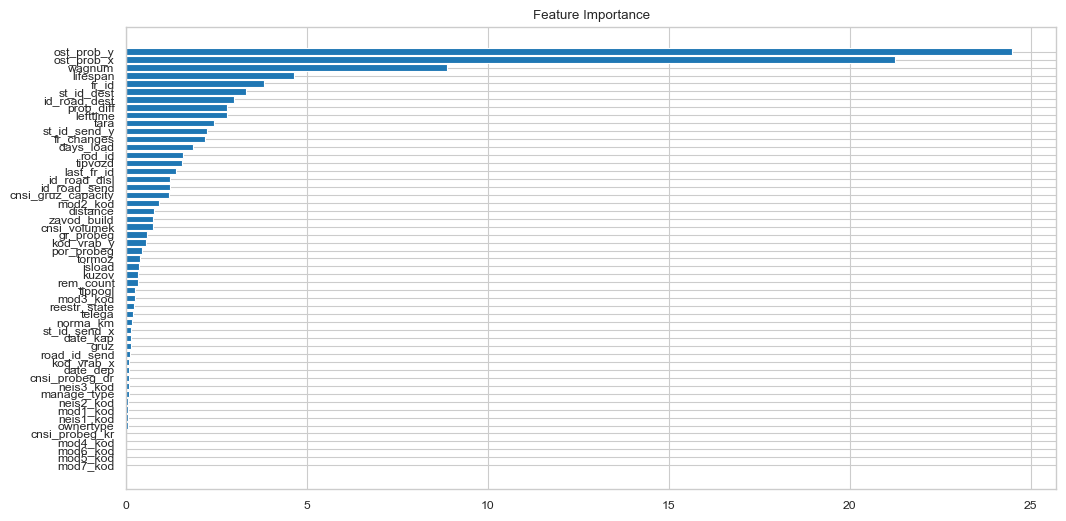

In [299]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

from tqdm import tqdm

import catboost as ctb
from catboost import Pool, cv

In [2]:
#visualization style
sns.set_context('paper')
sns.set_style('whitegrid')

from IPython.display import display
%matplotlib inline

In [3]:
#random state
RS = 121212

## Загрузка данных

In [4]:
path_train = r"D:\hack_DataWagon\Трек 2 - Чек-ап вагона\train"

In [589]:
# данные по дислокации
dislok = pd.read_parquet(path_train + '/dislok_wagons.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path_train + '/wagons_probeg_ownersip.parquet').convert_dtypes()
# параметры вагона
wag_param = pd.read_parquet(path_train + '/wag_params.parquet').convert_dtypes()
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path_train + '/tr_rems.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path_train + '/pr_rems.parquet').convert_dtypes()
#справочник грузов
fr_info = pd.read_parquet(path_train + '/freight_info.parquet').convert_dtypes()
#данные по кти
kti = pd.read_parquet(path_train + '/kti_izm.parquet').convert_dtypes()
#справочник станций
stations = pd.read_parquet(path_train + '/stations.parquet').convert_dtypes()


# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv(path_train +'/target/y_train.csv').convert_dtypes()

In [590]:
path_test = r"D:\hack_DataWagon\Трек 2 - Чек-ап вагона\test"

In [591]:
# данные по дислокации
dislok2 = pd.read_parquet(path_test + '/dislok_wagons.parquet').convert_dtypes()
# список вагонов с остаточным пробегом на момент прогноза
wag_prob2 = pd.read_parquet(path_test + '/wagons_probeg_ownersip.parquet').convert_dtypes()
# параметры вагона
wag_param2 = pd.read_parquet(path_test + '/wag_params.parquet').convert_dtypes()
# текущие ремонты вагонов
tr_rem2 = pd.read_parquet(path_test + '/tr_rems.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem2 = pd.read_parquet(path_test + '/pr_rems.parquet').convert_dtypes()
#справочник грузов
fr_info2 = pd.read_parquet(path_test + '/freight_info.parquet').convert_dtypes()
#данные по кти
kti2 = pd.read_parquet(path_test + '/kti_izm.parquet').convert_dtypes()
#справочник станций
stations2 = pd.read_parquet(path_test + '/stations.parquet').convert_dtypes()


# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target2 = pd.read_csv(path_test +'/target/y_test.csv').convert_dtypes()

Всего мы загружаем 8 таблиц с данными и 1 таблицу с таргетом.

In [592]:
dislok = pd.concat([dislok, dislok2])
wag_prob = pd.concat([wag_prob, wag_prob2])
wag_param = pd.concat([wag_param, wag_param2])
tr_rem = pd.concat([tr_rem, tr_rem2])
pr_rem = pd.concat([pr_rem, pr_rem2])
fr_info = pd.concat([fr_info, fr_info2])
kti = pd.concat([kti, kti2])
stations = pd.concat([stations, stations2])
target = pd.concat([target, target2])

## EDA

In [6]:
def missing_val(data):
    if sum(data.isna().sum().values) == 0:
        pass
    else:
        data_na = data.isna().sum().sort_values(ascending=False)/len(data)*100
        ax = data_na[data_na>0].plot(kind='bar', figsize=(15,2), grid=True, color='orangered')
        plt.ylim(0, 25)
        ax.set(xlabel="\nСтолбцы с пропущенными значениями",
        ylabel="\n% пропущенных значений")
        plt.xticks(rotation = 45, ha = 'right')
        plt.figure(figsize=(15, 3))
        import matplotlib.ticker as mtick
        ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.show()

In [7]:
def eda(data):
    print(data.info())
    display(data.head())
    data.hist(figsize=(15, 5), xrot=45, xlabelsize=5, ylabelsize=5)
    plt.show()
    print('Количество пропущенных значений:\n\n')
    print(data.isna().sum())
    print('')
    print('Процент пропусков')
    missing_val(data)
    print('')
    print('Количество дубликатов:\n\n',  data.duplicated().sum())

### Данные по дислокации

<class 'pandas.core.frame.DataFrame'>
Index: 6250933 entries, 0 to 1052924
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   plan_date     datetime64[us]
 1   wagnum        Int64         
 2   date_kap      datetime64[us]
 3   date_dep      datetime64[us]
 4   kod_vrab      Int64         
 5   date_pl_rem   datetime64[us]
 6   id_road_disl  Int64         
 7   st_id_dest    Int64         
 8   id_road_dest  Int64         
 9   st_id_send    Int64         
 10  id_road_send  Int64         
 11  ost_prob      Int64         
 12  isload        Int64         
 13  fr_id         Int64         
 14  last_fr_id    Int64         
 15  distance      Int64         
dtypes: Int64(12), datetime64[us](4)
memory usage: 882.3 MB
None


,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
0,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,22,42,11470,42,36899,0,5032,1413,-1
1,2022-08-02,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36899,1,1204,1204,998
2,2022-08-03,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,989
3,2022-08-04,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,939
4,2022-08-05,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,963


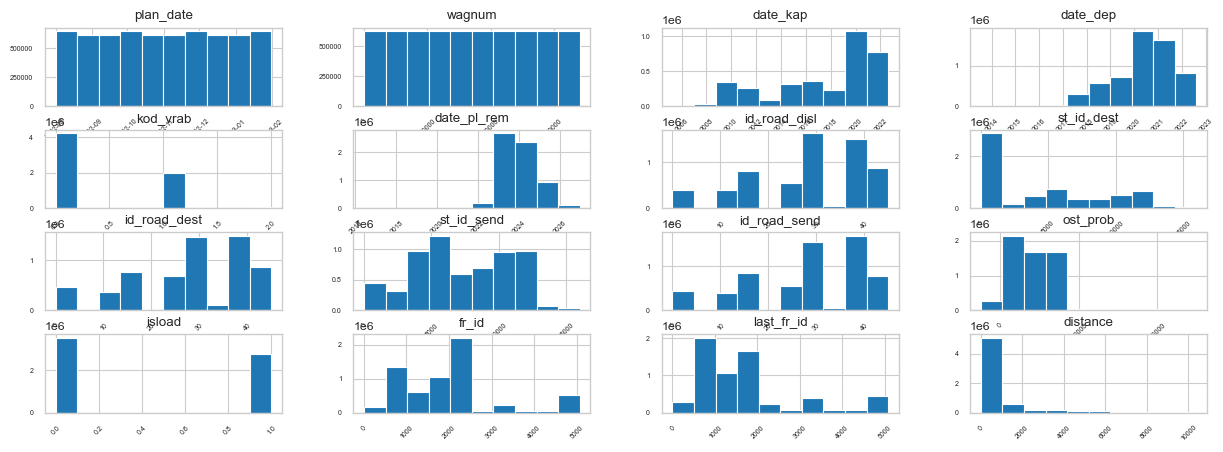

Количество пропущенных значений:


plan_date             0
wagnum                0
date_kap        2755031
date_dep         351873
kod_vrab              0
date_pl_rem           0
id_road_disl          0
st_id_dest            0
id_road_dest          0
st_id_send            0
id_road_send          0
ost_prob         257315
isload                0
fr_id                 0
last_fr_id            0
distance              0
dtype: int64

Процент пропусков


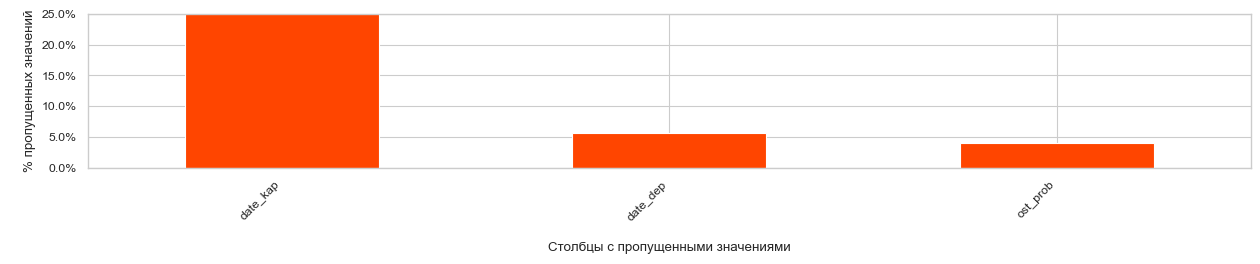

<Figure size 1500x300 with 0 Axes>


Количество дубликатов:

 24


In [8]:
eda(dislok)

### Данные по текущим ремонтам

<class 'pandas.core.frame.DataFrame'>
Index: 10441 entries, 0 to 1515
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wagnum        10441 non-null  Int64         
 1   rem_month     10441 non-null  datetime64[us]
 2   rod_id        10441 non-null  Int64         
 3   model         10441 non-null  string        
 4   road_id_send  10441 non-null  Int64         
 5   road_id_rem   10441 non-null  Int64         
 6   kod_vrab      10441 non-null  Int64         
 7   st_id_send    10441 non-null  Int64         
 8   st_id_rem     10441 non-null  Int64         
 9   distance      10441 non-null  Int64         
 10  month         10441 non-null  Int64         
dtypes: Int64(9), datetime64[us](1), string(1)
memory usage: 1.0 MB
None


,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
0,15000,2022-08-05,1,12-132,3,3,0,493,493,37,8
2,25485,2022-08-21,1,12-132-03,13,13,0,6152,4793,360,8
3,25944,2022-08-09,1,12-132-03,13,13,1,6152,4793,322,8
4,24080,2022-08-13,1,12-296-01,13,13,0,6152,4793,308,8
5,28612,2022-08-09,1,12-132,13,13,0,6152,4793,373,8


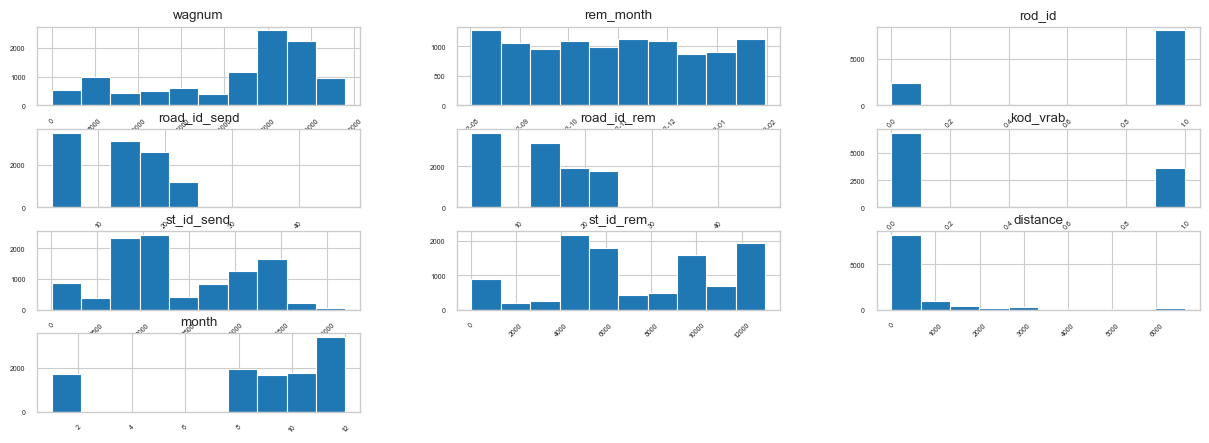

Количество пропущенных значений:


wagnum          0
rem_month       0
rod_id          0
model           0
road_id_send    0
road_id_rem     0
kod_vrab        0
st_id_send      0
st_id_rem       0
distance        0
month           0
dtype: int64

Процент пропусков

Количество дубликатов:

 0


In [9]:
eda(pr_rem)

### Текущие ремонты вагонов

<class 'pandas.core.frame.DataFrame'>
Index: 48652 entries, 0 to 7699
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   wagnum        48652 non-null  Int64         
 1   rem_month     48652 non-null  datetime64[us]
 2   kod_vrab      48652 non-null  Int64         
 3   neis1_kod     48652 non-null  Int64         
 4   neis2_kod     48652 non-null  Int64         
 5   neis3_kod     48652 non-null  Int64         
 6   mod1_kod      48652 non-null  Int64         
 7   mod2_kod      48652 non-null  Int64         
 8   mod3_kod      48652 non-null  Int64         
 9   mod4_kod      48652 non-null  Int32         
 10  mod5_kod      48652 non-null  Int32         
 11  mod6_kod      48652 non-null  Int32         
 12  mod7_kod      48652 non-null  Int32         
 13  road_id_send  48652 non-null  Int64         
 14  gr_probeg     47920 non-null  Int64         
 15  por_probeg    47977 non-null  Int64       

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send
0,29938,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,38,87913,37467,10522
1,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,38,87913,37467,10441
2,29852,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
3,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
4,13674,2022-08-01,2,95,98,54,7,4,2,0,0,0,0,28,64130,34697,4789


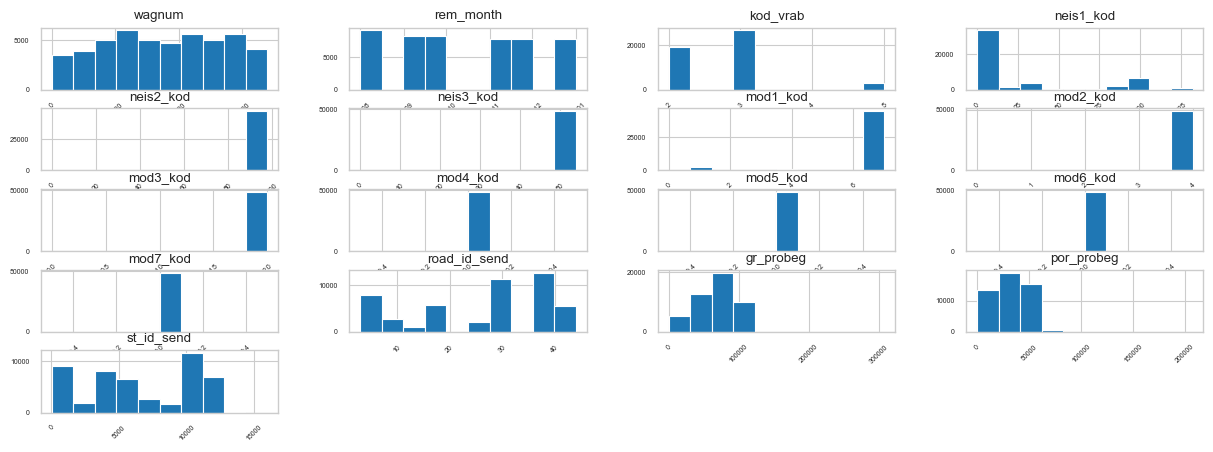

Количество пропущенных значений:


wagnum            0
rem_month         0
kod_vrab          0
neis1_kod         0
neis2_kod         0
neis3_kod         0
mod1_kod          0
mod2_kod          0
mod3_kod          0
mod4_kod          0
mod5_kod          0
mod6_kod          0
mod7_kod          0
road_id_send      0
gr_probeg       732
por_probeg      675
st_id_send        0
dtype: int64

Процент пропусков


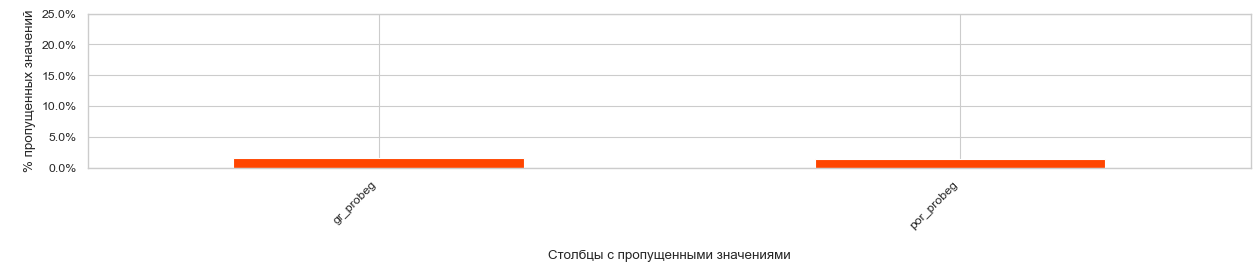

<Figure size 1500x300 with 0 Axes>


Количество дубликатов:

 166


In [10]:
eda(tr_rem)

### Список вагонов с остаточным пробегом на момент прогноза

In [11]:
wag_prob.repdate.min()

Timestamp('2022-08-01 00:00:00')

In [12]:
wag_prob.repdate.max()

Timestamp('2023-01-31 00:00:00')

<class 'pandas.core.frame.DataFrame'>
Index: 6249857 entries, 0 to 9249588
Data columns (total 8 columns):
 #   Column          Dtype         
---  ------          -----         
 0   repdate         datetime64[us]
 1   wagnum          Int64         
 2   ost_prob        Int64         
 3   manage_type     Int64         
 4   rod_id          Int64         
 5   reestr_state    Int64         
 6   ownership_type  Int64         
 7   month           Int64         
dtypes: Int64(7), datetime64[us](1)
memory usage: 470.9 MB
None


,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
1,2022-08-02,33361,7243,0,1,1,0,8
2,2022-08-03,33361,6990,0,1,1,0,8
3,2022-08-04,33361,6347,0,1,1,0,8
4,2022-08-05,33361,6027,0,1,1,0,8


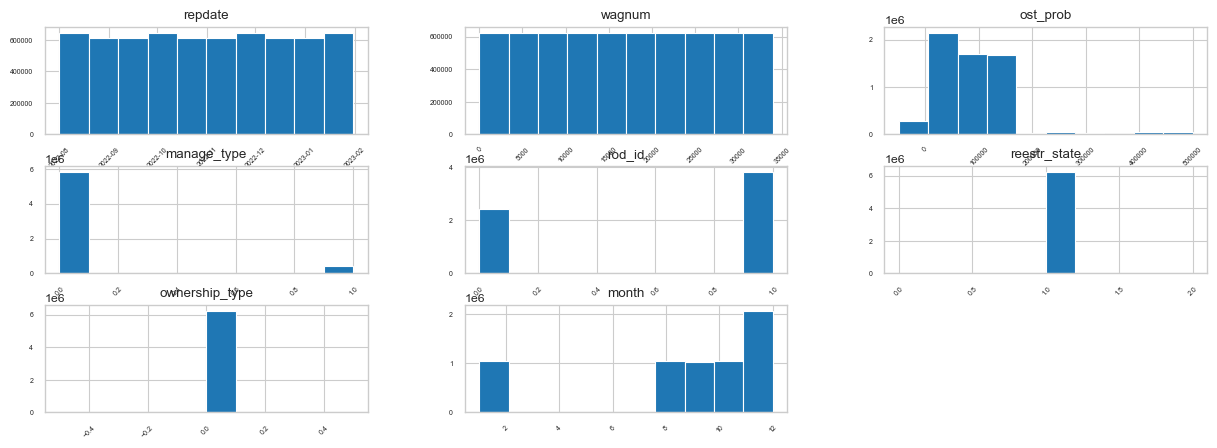

Количество пропущенных значений:


repdate                0
wagnum                 0
ost_prob          256959
manage_type            0
rod_id                 0
reestr_state           0
ownership_type         0
month                  0
dtype: int64

Процент пропусков


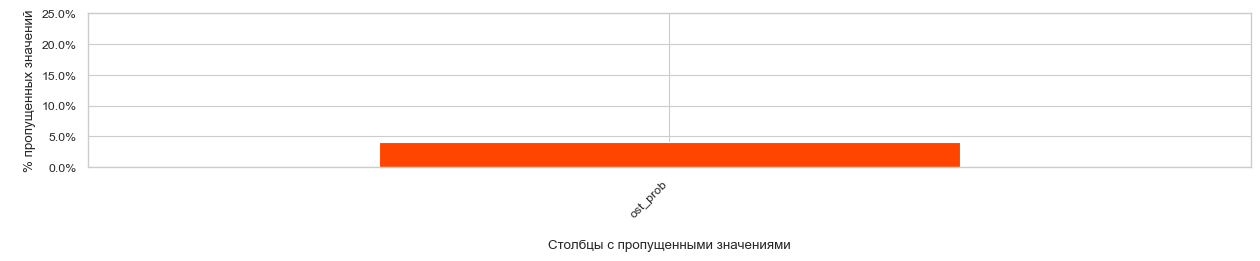

<Figure size 1500x300 with 0 Axes>


Количество дубликатов:

 0


In [13]:
eda(wag_prob)

In [444]:
wag_prob.head()

,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
1,2022-08-02,33361,7243,0,1,1,0,8
2,2022-08-03,33361,6990,0,1,1,0,8
3,2022-08-04,33361,6347,0,1,1,0,8
4,2022-08-05,33361,6027,0,1,1,0,8


In [480]:
wag_uniq = wag_prob['wagnum'].unique()[:10]

In [484]:
wag_uniq

<IntegerArray>
[33361, 33364, 33366, 33358, 33349, 33354, 33355, 33356, 33370, 33373]
Length: 10, dtype: Int64

In [482]:
data=wag_prob.query('wagnum in @wag_uniq')

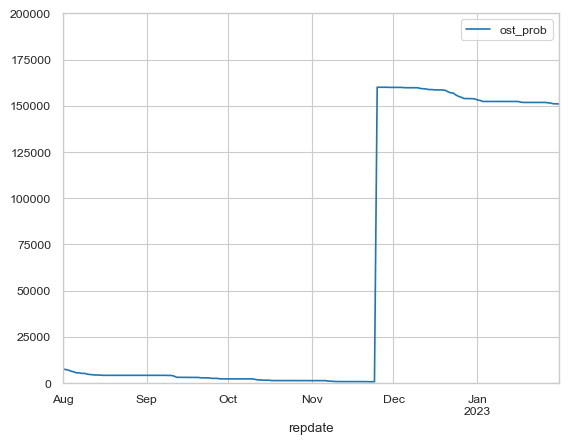

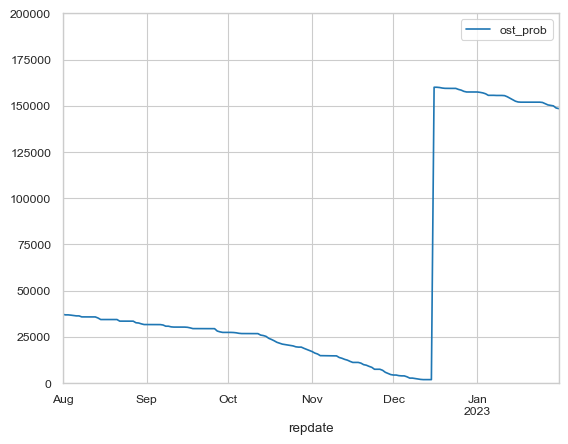

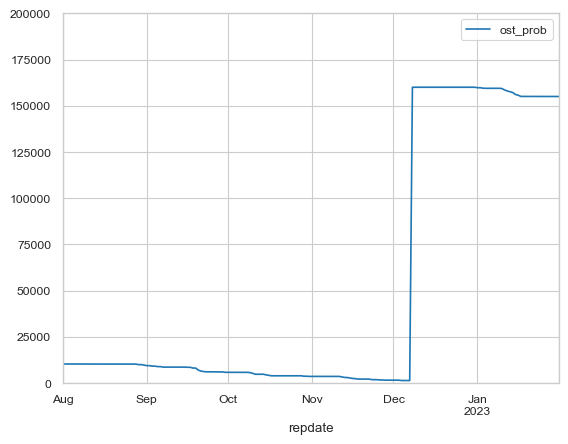

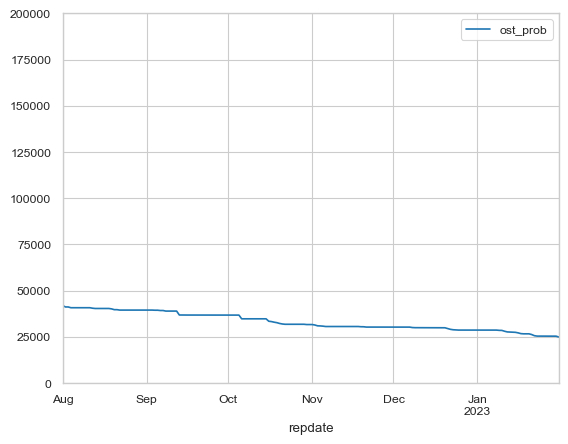

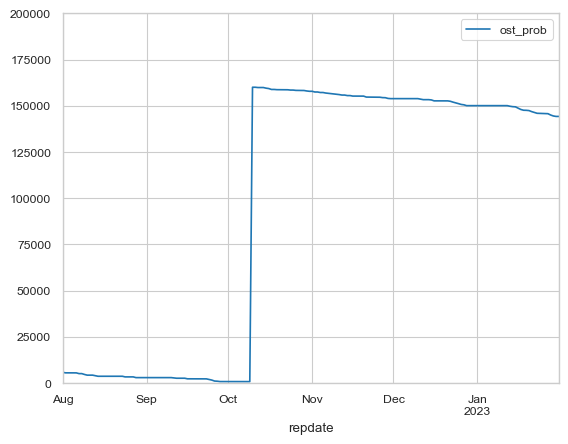

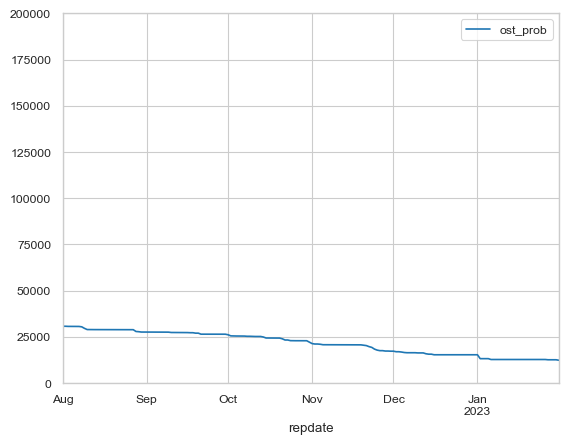

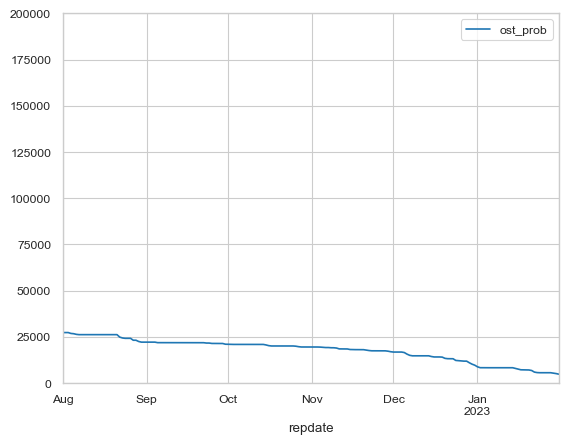

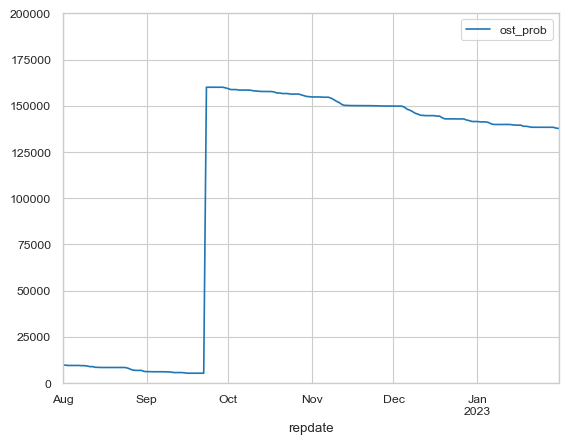

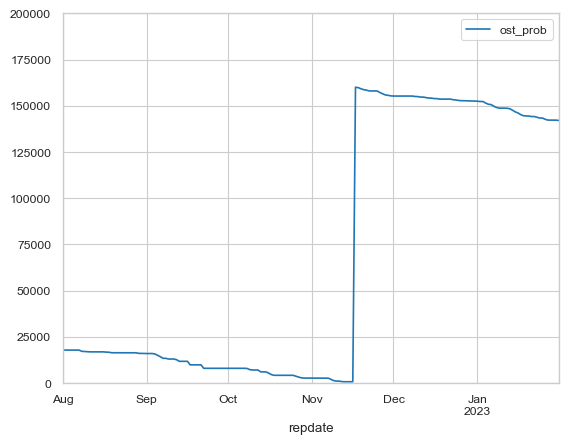

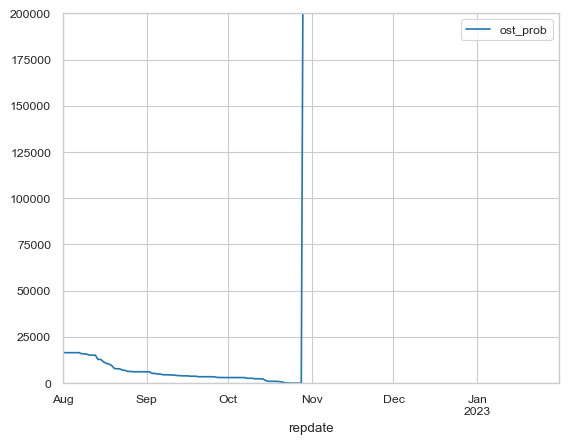

In [491]:
for x in wag_uniq:
    
    data[data['wagnum'] == x].plot('repdate', 'ost_prob')
    plt.ylim(0, 200000)
    plt.show()

### Справочник грузов

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5079 entries, 0 to 5078
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   fr_id       5079 non-null   Int64
 1   fr_class    5079 non-null   Int64
 2   skoroport   5079 non-null   Int64
 3   naval       5079 non-null   Int64
 4   nasip       5079 non-null   Int64
 5   naliv       5079 non-null   Int64
 6   openvagons  5079 non-null   Int64
 7   soprovod    5079 non-null   Int64
 8   smerz       5079 non-null   Int64
dtypes: Int64(9)
memory usage: 401.9 KB
None


,fr_id,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,4989,2,0,0,0,0,0,0,0
1,4990,2,0,0,0,0,0,0,0
2,4991,0,0,0,0,0,0,0,0
3,4992,2,0,0,0,0,0,0,0
4,4993,2,0,0,0,0,0,0,0


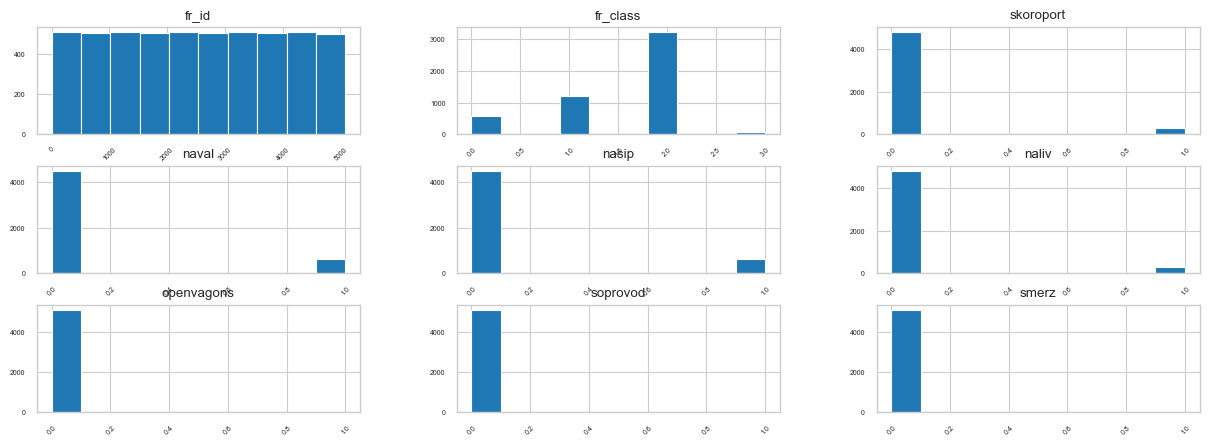

Количество пропущенных значений:


fr_id         0
fr_class      0
skoroport     0
naval         0
nasip         0
naliv         0
openvagons    0
soprovod      0
smerz         0
dtype: int64

Процент пропусков

Количество дубликатов:

 0


In [14]:
eda(fr_info)

### Данные по кти

<class 'pandas.core.frame.DataFrame'>
Index: 22428 entries, 43 to 212366
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   wagnum               22428 non-null  Int64  
 1   operation_date_dttm  22428 non-null  object 
 2   mileage_all          22155 non-null  Int64  
 3   axl1_l_w_flange      22416 non-null  Float64
 4   axl1_r_w_flange      22409 non-null  Float64
 5   axl2_l_w_flange      22412 non-null  Float64
 6   axl2_r_w_flange      22408 non-null  Float64
 7   axl3_l_w_flange      22411 non-null  Float64
 8   axl3_r_w_flange      22407 non-null  Float64
 9   axl4_l_w_flange      22413 non-null  Float64
 10  axl4_r_w_flange      22416 non-null  Float64
 11  axl1_l_w_rim         22287 non-null  Float64
 12  axl1_r_w_rim         22296 non-null  Float64
 13  axl2_l_w_rim         22293 non-null  Float64
 14  axl2_r_w_rim         22292 non-null  Float64
 15  axl3_l_w_rim         22251 non-null  Fl

,wagnum,operation_date_dttm,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim
43,1302,2023-02-17,67638,29.6,29.5,30.0,29.6,30.2,29.9,30.9,29.5,37.8,39.2,39.5,38.9,41.8,38.9,36.5,38.2
60,1374,2023-02-25,83798,29.1,27.9,27.7,29.1,29.3,30.2,29.4,27.5,48.9,49.0,49.7,51.0,30.7,32.4,30.6,28.8
137,2916,2023-02-21,121660,30.4,26.5,30.8,28.2,26.9,27.1,29.8,31.2,69.2,66.7,66.8,63.7,66.1,66.3,68.1,67.6
196,3849,2023-02-19,59664,30.6,29.2,31.6,28.5,31.0,30.7,29.3,30.0,75.1,76.1,74.8,73.7,75.6,76.8,72.2,72.9
197,3849,2023-02-20,59664,30.9,28.7,32.4,28.1,31.0,29.7,30.5,29.9,75.6,76.8,74.1,74.7,75.8,77.0,74.9,74.2


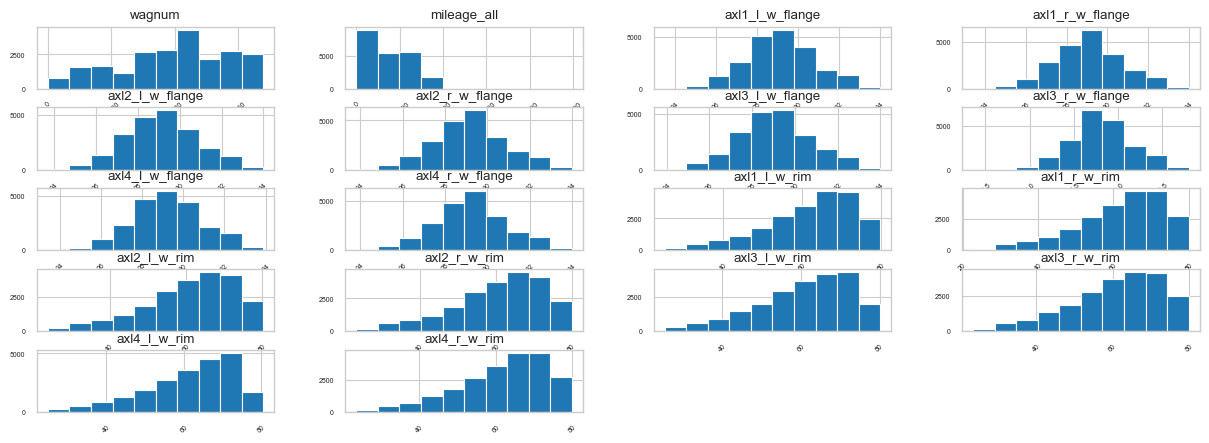

Количество пропущенных значений:


wagnum                   0
operation_date_dttm      0
mileage_all            273
axl1_l_w_flange         12
axl1_r_w_flange         19
axl2_l_w_flange         16
axl2_r_w_flange         20
axl3_l_w_flange         17
axl3_r_w_flange         21
axl4_l_w_flange         15
axl4_r_w_flange         12
axl1_l_w_rim           141
axl1_r_w_rim           132
axl2_l_w_rim           135
axl2_r_w_rim           136
axl3_l_w_rim           177
axl3_r_w_rim           155
axl4_l_w_rim           122
axl4_r_w_rim           110
dtype: int64

Процент пропусков


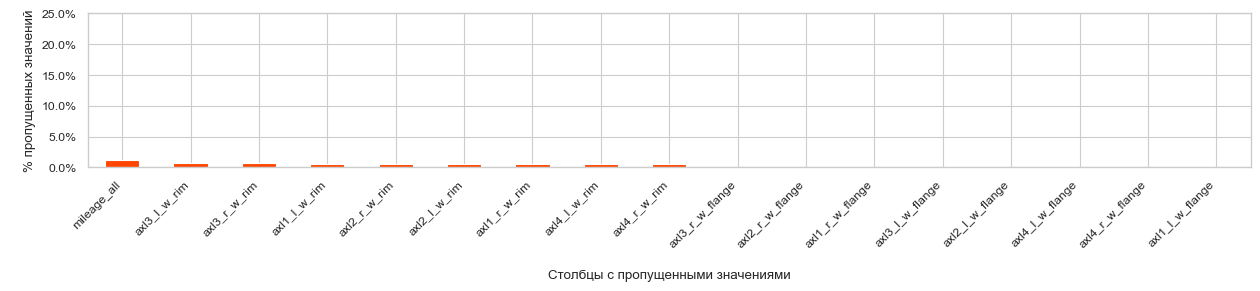

<Figure size 1500x300 with 0 Axes>


Количество дубликатов:

 0


In [15]:
eda(kti)

### Параметры вагона

<class 'pandas.core.frame.DataFrame'>
Index: 33977 entries, 3218 to 33707
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   wagnum              33977 non-null  Int64         
 1   model               33977 non-null  string        
 2   rod_id              33977 non-null  Int64         
 3   gruz                33977 non-null  Int64         
 4   cnsi_gruz_capacity  33977 non-null  Int64         
 5   cnsi_volumek        33977 non-null  Float64       
 6   tara                33977 non-null  Int64         
 7   date_build          33977 non-null  datetime64[ms]
 8   srok_sl             33977 non-null  datetime64[ms]
 9   zavod_build         33977 non-null  Int64         
 10  date_iskl           116 non-null    datetime64[ms]
 11  cnsi_probeg_dr      33977 non-null  Int64         
 12  cnsi_probeg_kr      33977 non-null  Int64         
 13  kuzov               33977 non-null  Int64       

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1


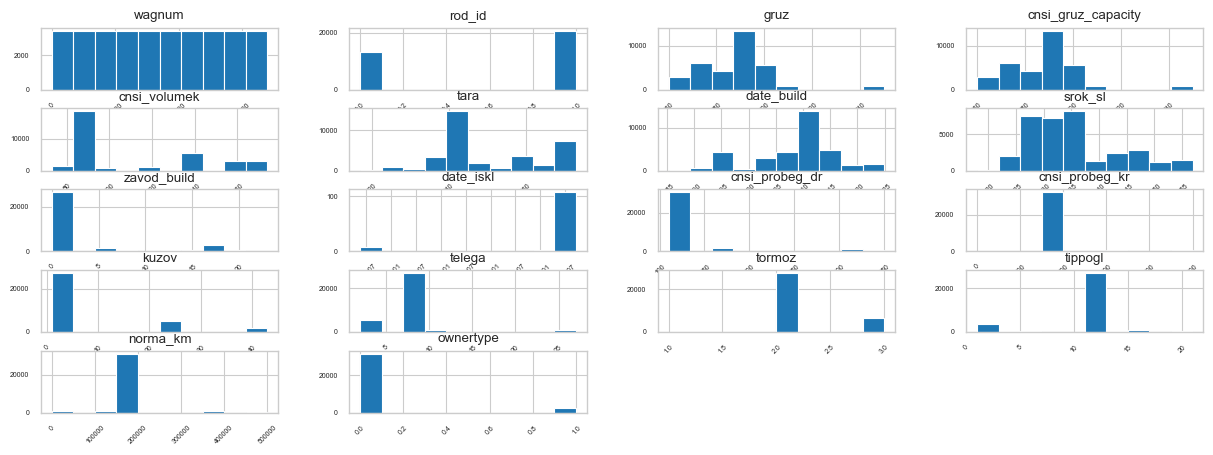

Количество пропущенных значений:


wagnum                    0
model                     0
rod_id                    0
gruz                      0
cnsi_gruz_capacity        0
cnsi_volumek              0
tara                      0
date_build                0
srok_sl                   0
zavod_build               0
date_iskl             33861
cnsi_probeg_dr            0
cnsi_probeg_kr            0
kuzov                     0
telega                    0
tormoz                    0
tipvozd                   0
tippogl                  59
norma_km                  0
ownertype                 0
dtype: int64

Процент пропусков


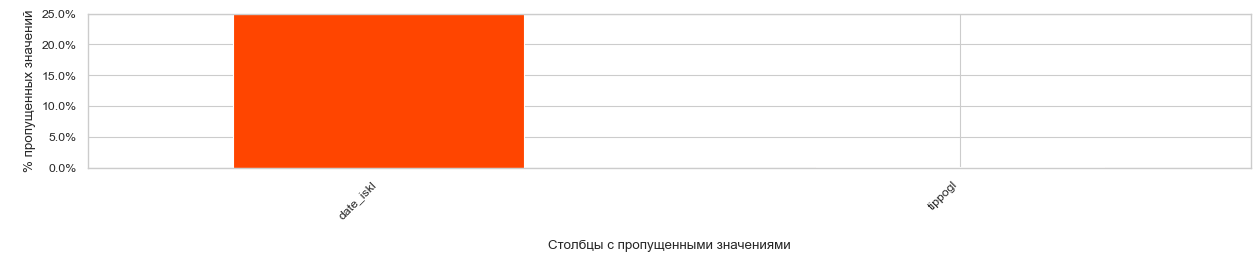

<Figure size 1500x300 with 0 Axes>


Количество дубликатов:

 0


In [16]:
eda(wag_param)

### Таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней

In [17]:
target['wagnum'].value_counts().sort_values()

wagnum
33350    1
8061     5
26318    5
8099     5
28344    5
        ..
21361    6
7479     6
22774    6
16236    6
22769    6
Name: count, Length: 33977, dtype: Int64

In [18]:
target.query('wagnum == 33350')

,wagnum,month,target_month,target_day
203852,33350,2022-12-01,1,0


In [19]:
target.query('wagnum == 8061')

,wagnum,month,target_month,target_day
33972,8061,2023-01-01,0,0
101923,8061,2022-09-01,1,0
135899,8061,2022-10-01,0,0
169875,8061,2022-11-01,0,0
203851,8061,2022-12-01,0,0


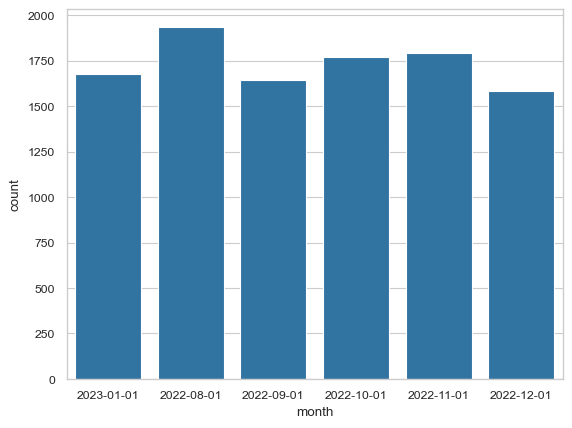

In [20]:
sns.countplot(x='month', data=target.query('target_month == 1'))
plt.show()

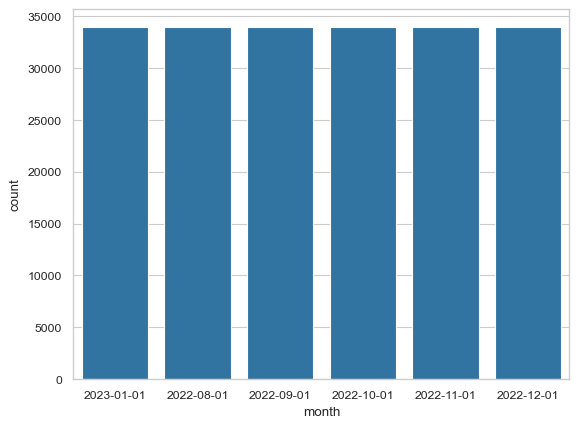

In [21]:
sns.countplot(x='month', data=target)
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203853 entries, 0 to 203852
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   wagnum        203853 non-null  Int64 
 1   month         203853 non-null  string
 2   target_month  203853 non-null  Int64 
 3   target_day    203853 non-null  Int64 
dtypes: Int64(3), string(1)
memory usage: 6.8 MB
None


,wagnum,month,target_month,target_day
0,33361,2023-01-01,0,0
1,33364,2023-01-01,0,0
2,33366,2023-01-01,0,0
3,33358,2023-01-01,0,0
4,33349,2023-01-01,0,0


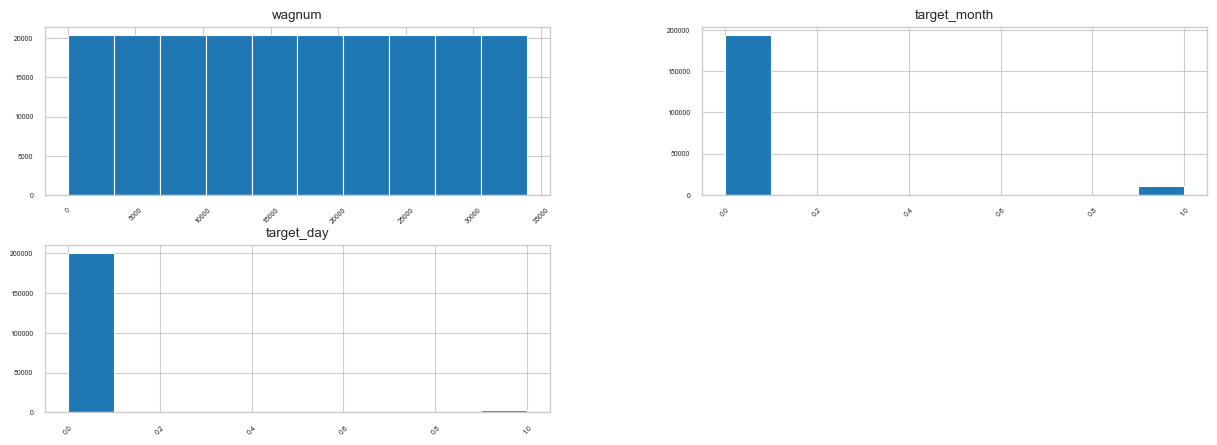

Количество пропущенных значений:


wagnum          0
month           0
target_month    0
target_day      0
dtype: int64

Процент пропусков

Количество дубликатов:

 0


In [22]:
eda(target)

In [23]:
target['month'].min()

'2022-08-01'

In [24]:
target['month'].max()

'2023-01-01'

## ML-Baseline

### Создание таблицы

Оставим только последнее упоминание вагона из списка:

In [593]:
wag_dec = wag_prob[(wag_prob['repdate'] < '2023-02-01') & (wag_prob['repdate'] >= '2023-01-01')].copy()

In [594]:
wag_dec = wag_dec.groupby('wagnum').agg({'repdate':'max'})

In [595]:
wag_dec.reset_index(inplace=True)

Удалим колонки ownership_type, month, предположив, что они не влияют на предсказание

In [596]:
wag_dec = pd.merge(wag_dec, wag_prob,  how='left', left_on=['wagnum','repdate'], right_on = ['wagnum','repdate'])

In [597]:
wag_dec.drop(columns=['ownership_type', 'month'], inplace=True)

In [598]:
wag_dec.head()

,wagnum,repdate,ost_prob,manage_type,rod_id,reestr_state
0,0,2023-01-31,52852,0,0,1
1,1,2023-01-31,93045,0,0,1
2,2,2023-01-31,53122,0,0,1
3,3,2023-01-31,55940,0,0,1
4,4,2023-01-31,90612,0,0,1


Оставим таргет только за последний февраль:

In [599]:
target_feb = target[target['month'] == '2023-02-01']

In [601]:
target_feb.head(3)

,wagnum,month,target_month,target_day
0,33361,2023-02-01,0,0
1,33364,2023-02-01,0,0
2,33366,2023-02-01,0,0


Присоединим таргет к табличке по номеру вагона:

In [602]:
wag_dec = wag_dec.merge(target_feb, how='left', on='wagnum')
wag_dec.head()

,wagnum,repdate,ost_prob,manage_type,rod_id,reestr_state,month,target_month,target_day
0,0,2023-01-31,52852,0,0,1,2023-02-01,0,0
1,1,2023-01-31,93045,0,0,1,2023-02-01,0,0
2,2,2023-01-31,53122,0,0,1,2023-02-01,0,0
3,3,2023-01-31,55940,0,0,1,2023-02-01,0,0
4,4,2023-01-31,90612,0,0,1,2023-02-01,0,0


Удалим номера, месяцы:

In [603]:
wag_dec.drop(columns=['repdate', 'wagnum', 'month'], inplace=True)

### Деление на выборки

In [604]:
wag_dec.isna().sum()

ost_prob        1229
manage_type        0
rod_id             0
reestr_state       0
target_month     265
target_day       265
dtype: int64

In [605]:
wag_dec.dropna(inplace=True)

In [606]:
wag_dec.head(3)

,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day
0,52852,0,0,1,0,0
1,93045,0,0,1,0,0
2,53122,0,0,1,0,0


In [607]:
features = wag_dec.drop(columns=['target_month', 'target_day'])
target_m = wag_dec['target_month']
target_d = wag_dec['target_day']

In [608]:
features_train, features_valid, target_train_m, target_valid_m = \
        train_test_split(features, target_m, test_size=0.2, random_state=RS, stratify=target_m)

### Обучение модели

In [609]:
cat_features = ['manage_type', 'rod_id', 'reestr_state']

In [610]:
model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')

In [611]:
from sklearn.metrics import f1_score, make_scorer

f1 = make_scorer(f1_score , average='macro')

In [612]:
from catboost import Pool, cv

In [613]:
pool_train = Pool(features_train, label=target_train_m, cat_features=cat_features)

In [614]:
params = {
    'iterations': [300],
    'custom_loss': ['F1'],
    'learning_rate': [0.1, 0.2],
    'depth': [3, 6, 9]
}

In [615]:
#для подбора
gs = model.grid_search(params, X=pool_train)

0:	loss: 0.0765335	best: 0.0765335 (0)	total: 2.81s	remaining: 14.1s
1:	loss: 0.0774297	best: 0.0765335 (0)	total: 5.51s	remaining: 11s
2:	loss: 0.0763560	best: 0.0763560 (2)	total: 8.67s	remaining: 8.67s
3:	loss: 0.0762249	best: 0.0762249 (3)	total: 11.9s	remaining: 5.93s
4:	loss: 0.0770245	best: 0.0762249 (3)	total: 16.4s	remaining: 3.28s
5:	loss: 0.0768540	best: 0.0762249 (3)	total: 21.2s	remaining: 0us
Estimating final quality...


In [616]:
gs['params']

{'depth': 6, 'iterations': 300, 'learning_rate': 0.2, 'custom_metric': 'F1'}

In [617]:
gs['params']['loss_function']='Logloss'

In [618]:
cv_data = cv(
    params=gs['params'],
    pool=Pool(features_train, label=target_train_m),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=RS,
    plot=True,
    stratified=True, 
    verbose=False,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.0821360025
bestIteration = 32

Training on fold [1/5]

bestTest = 0.07902127853
bestIteration = 47

Training on fold [2/5]

bestTest = 0.08717316248
bestIteration = 13

Training on fold [3/5]

bestTest = 0.08449857148
bestIteration = 39

Training on fold [4/5]

bestTest = 0.08756243089
bestIteration = 39



In [619]:
ctb_f1_valid = cv_data['test-F1-mean'].tail(1)

In [620]:
ctb_f1_valid

299    0.474046
Name: test-F1-mean, dtype: float64

In [621]:
model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=300,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.2,
    depth=6,                    
    verbose=False)

In [622]:
model.fit(features_train, target_train_m)

In [623]:
pred = model.predict(features_valid)

In [624]:
f1_score(target_valid_m, pred)

0.4628450106157112

In [240]:
model.feature_importances_

array([85.22130072,  3.24826454, 11.37076855,  0.15966619])

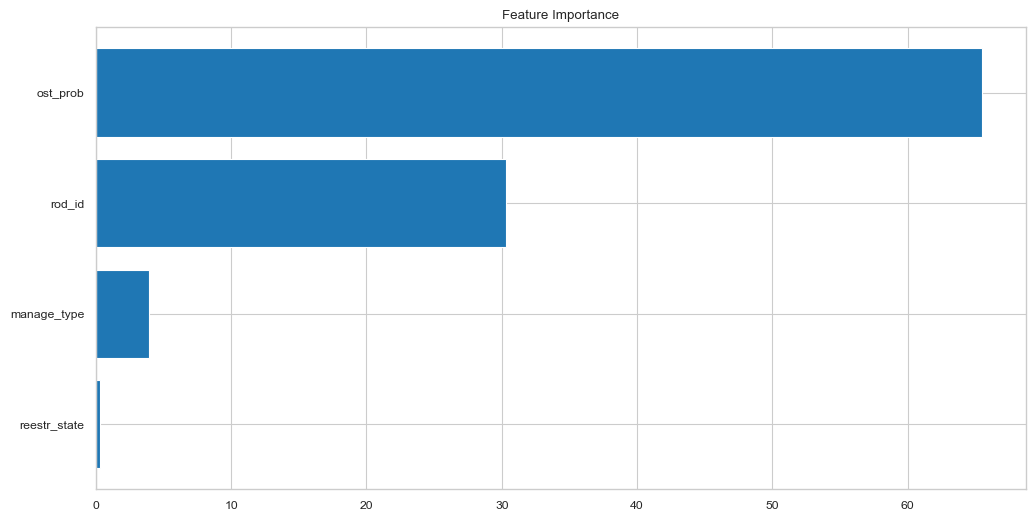

In [625]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_valid.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [242]:
features

,ost_prob,manage_type,rod_id,reestr_state
0,57742,0,0,1
1,93069,0,0,1
2,56136,0,0,1
3,66998,0,0,1
4,98483,0,0,1
...,...,...,...,...
33972,152757,0,1,1
33973,143405,0,1,1
33974,155168,0,1,1
33975,151199,0,1,1


In [243]:
import shap

shap.initjs()

In [244]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(features_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


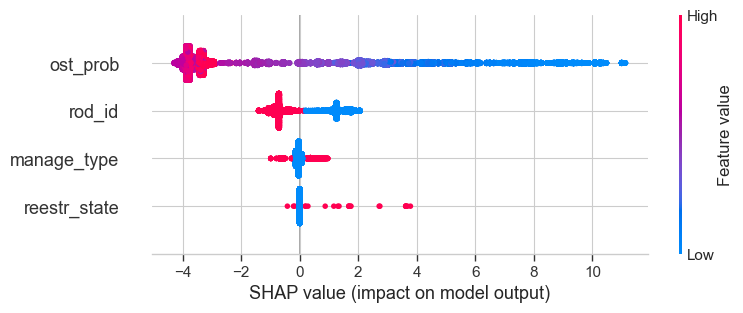

In [245]:
shap.plots.beeswarm(shap_values)

## Функция для обучения

In [1302]:
def trainer(wag_dec, cat_features, params):
    
    features = wag_dec.drop(columns=['target_month', 'target_day'])
    target_m = wag_dec['target_month']
    target_d = wag_dec['target_day']
    
    features_train, features_valid, target_train_m, target_valid_m = \
        train_test_split(features, target_m, test_size=0.2, random_state=RS, stratify=target_m)
    
    model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')
    
    pool_train = Pool(features_train, label=target_train_m, cat_features=cat_features)
    
    
    #для подбора
    gs = model.grid_search(params, X=pool_train)
    
    gs['params']['loss_function']='Logloss'
    
    cv_data = cv(
    params=gs['params'],
    pool=Pool(features_train, label=target_train_m, cat_features=cat_features),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=RS,
    plot=True,
    stratified=True, 
    verbose=False,
    )
    
    ctb_f1_valid = cv_data['test-F1-mean'].tail(1)
    print(ctb_f1_valid)
    
    model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=300,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.1,
    depth=9,                    
    verbose=False,
    cat_features=cat_features)
    
    model.fit(features_train, target_train_m)
    
    pred = model.predict(features_valid)
    
    f1 = f1_score(target_valid_m, pred)
    print(f1)
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(features_valid.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    

In [1305]:
def trainer_d(wag_dec, cat_features, params):
    
    features = wag_dec.drop(columns=['target_month', 'target_day'])
    target_m = wag_dec['target_month']
    target_d = wag_dec['target_day']
    
    features_train, features_valid, target_train_d, target_valid_d = \
        train_test_split(features, target_d, test_size=0.2, random_state=RS, stratify=target_d)
    
    model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')
    
    pool_train = Pool(features_train, label=target_train_d, cat_features=cat_features)
    
    
    #для подбора
    gs = model.grid_search(params, X=pool_train)
    
    gs['params']['loss_function']='Logloss'
    
    cv_data = cv(
    params=gs['params'],
    pool=Pool(features_train, label=target_train_d, cat_features=cat_features),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=RS,
    plot=True,
    stratified=True, 
    verbose=False,
    )
    
    ctb_f1_valid = cv_data['test-F1-mean'].tail(1)
    print(ctb_f1_valid)
   
    model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=300,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.1,
    depth=9,                    
    verbose=False,
    cat_features=cat_features)
    
    model.fit(features_train, target_train_d)
    
    pred = model.predict(features_valid)
    
    f1 = f1_score(target_valid_d, pred)
    print(f1)
    
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize=(12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(features_valid.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    

## Датасет 

### Создание и объединение таблиц с таргетом и номерами вагонов по месяцам

In [626]:
def month_table(wag_prob, target, month_df, month_t):
    wag_filtr = wag_prob[(wag_prob['repdate'] < month_t) & (wag_prob['repdate'] >= month_df)].copy()
    wag_dec = wag_filtr.groupby('wagnum').agg({'repdate':'max'})
    wag_dec.reset_index(inplace=True)
    wag_dec = pd.merge(wag_dec, wag_prob,  how='left', left_on=['wagnum','repdate'], right_on = ['wagnum','repdate'])
    wag_dec.drop(columns=['ownership_type', 'month'], inplace=True)

    target_jan = target[target['month'] == month_t]
    wag_dec = wag_dec.merge(target_jan, how='left', on='wagnum')
    wag_dec.drop(columns=['repdate', 'month'], inplace=True)
    
    #создаем параметр разницы пробега в конце месяца и начале
    wag_max = wag_filtr.groupby('wagnum').agg({'repdate':'max'})
    wag_min = wag_filtr.groupby('wagnum').agg({'repdate':'min'})
    
    wag_max.reset_index(inplace=True)
    wag_min.reset_index(inplace=True)
    
    prob_diff = []
    wag_to_diff = []
    for i in tqdm(range(len(wag_max))):
        max_max = wag_filtr[(wag_filtr['repdate'] == wag_max.iloc[i]['repdate'])&(wag_filtr['wagnum'] == wag_max.iloc[i]['wagnum'])]['ost_prob'].iloc[0]
        min_min = wag_filtr[(wag_filtr['repdate'] == wag_min.loc[i]['repdate'])&(wag_filtr['wagnum'] == wag_min.iloc[i]['wagnum'])]['ost_prob'].iloc[0]
        prob_diff.append(max_max - min_min) 
        wag_to_diff.append(wag_max.iloc[i]['wagnum'])
        
    wag_and_diff = pd.DataFrame({'wagnum':wag_to_diff,
                             'prob_diff':prob_diff})    
    wag_dec = wag_dec.merge(wag_and_diff, how='left', on='wagnum')
    return wag_dec

In [627]:
wag_jan = month_table(wag_prob, target, '2023-01-01', '2023-02-01')

100%|████████████████████████████████████████████████████████████████████████████| 33973/33973 [10:43<00:00, 52.76it/s]


In [639]:
wag_dec = month_table(wag_prob, target, '2022-12-01', '2023-01-01')

100%|████████████████████████████████████████████████████████████████████████████| 33977/33977 [11:00<00:00, 51.46it/s]


In [655]:
wag_nov = month_table(wag_prob, target, '2022-11-01', '2022-12-01')

100%|████████████████████████████████████████████████████████████████████████████| 33977/33977 [05:54<00:00, 95.82it/s]


In [682]:
wag_oct = month_table(wag_prob, target, '2022-10-01', '2022-11-01')

100%|████████████████████████████████████████████████████████████████████████████| 33976/33976 [10:35<00:00, 53.48it/s]


In [683]:
wag_sep = month_table(wag_prob, target, '2022-09-01', '2022-10-01')

100%|████████████████████████████████████████████████████████████████████████████| 33976/33976 [06:20<00:00, 89.39it/s]


In [684]:
wag_aug = month_table(wag_prob, target, '2022-08-01', '2022-09-01')

100%|████████████████████████████████████████████████████████████████████████████| 33975/33975 [10:20<00:00, 54.76it/s]


In [695]:
nm = ['2023-01-01', '2022-12-01', '2022-11-01', '2022-10-01', '2022-09-01', '2022-08-01' ]
mm = [wag_jan, wag_dec, wag_nov, wag_oct, wag_sep, wag_aug]

for i in range(len(mm)):
    mm[i]['month'] = nm[i]

In [704]:
for i in range(len(mm)):
    mm[i]['month'] = pd.to_datetime(mm[i]['month'])

In [706]:
meta_wag = pd.concat([wag_jan, wag_dec, wag_nov, wag_oct, wag_sep, wag_aug], ignore_index=True)

In [707]:
meta_wag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203854 entries, 0 to 203853
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   wagnum        203854 non-null  Int64         
 1   ost_prob      195693 non-null  Int64         
 2   manage_type   203854 non-null  Int64         
 3   rod_id        203854 non-null  Int64         
 4   reestr_state  203854 non-null  Int64         
 5   target_month  203585 non-null  Int64         
 6   target_day    203585 non-null  Int64         
 7   prob_diff     195184 non-null  object        
 8   month         203854 non-null  datetime64[ns]
dtypes: Int64(7), datetime64[ns](1), object(1)
memory usage: 15.4+ MB


In [708]:
#meta_wag.to_csv('meta_wag.csv')

In [709]:
meta_wag.head()

,wagnum,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,month
0,0,52852,0,0,1,0,0,-4158,2023-01-01
1,1,93045,0,0,1,0,0,-24,2023-01-01
2,2,53122,0,0,1,0,0,-3014,2023-01-01
3,3,55940,0,0,1,0,0,-11058,2023-01-01
4,4,90612,0,0,1,0,0,-7261,2023-01-01


In [710]:
#backup = meta_wag.copy()

In [711]:
meta_wag.isna().sum()

wagnum             0
ost_prob        8161
manage_type        0
rod_id             0
reestr_state       0
target_month     269
target_day       269
prob_diff       8670
month              0
dtype: int64

In [712]:
meta_wag.dropna(inplace=True)
meta_wag.reset_index(drop=True, inplace=True)

In [713]:
meta_wag.isna().sum()

wagnum          0
ost_prob        0
manage_type     0
rod_id          0
reestr_state    0
target_month    0
target_day      0
prob_diff       0
month           0
dtype: int64

#### Создаем фичи для февраля

In [722]:
def month_feb(wag_prob, month_df, month_t):
    wag_filtr = wag_prob[(wag_prob['repdate'] < month_t) & (wag_prob['repdate'] >= month_df)].copy()
    wag_dec = wag_filtr.groupby('wagnum').agg({'repdate':'max'})
    wag_dec.reset_index(inplace=True)
    wag_dec = pd.merge(wag_dec, wag_prob,  how='left', left_on=['wagnum','repdate'], right_on = ['wagnum','repdate'])
    wag_dec.drop(columns=['ownership_type', 'month'], inplace=True)
    
    #создаем параметр разницы пробега в конце месяца и начале
    wag_max = wag_filtr.groupby('wagnum').agg({'repdate':'max'})
    wag_min = wag_filtr.groupby('wagnum').agg({'repdate':'min'})
    
    wag_max.reset_index(inplace=True)
    wag_min.reset_index(inplace=True)
    
    prob_diff = []
    wag_to_diff = []
    for i in tqdm(range(len(wag_max))):
        max_max = wag_filtr[(wag_filtr['repdate'] == wag_max.iloc[i]['repdate'])&(wag_filtr['wagnum'] == wag_max.iloc[i]['wagnum'])]['ost_prob'].iloc[0]
        min_min = wag_filtr[(wag_filtr['repdate'] == wag_min.loc[i]['repdate'])&(wag_filtr['wagnum'] == wag_min.iloc[i]['wagnum'])]['ost_prob'].iloc[0]
        prob_diff.append(max_max - min_min) 
        wag_to_diff.append(wag_max.iloc[i]['wagnum'])
        
    wag_and_diff = pd.DataFrame({'wagnum':wag_to_diff,
                             'prob_diff':prob_diff})    
    wag_dec = wag_dec.merge(wag_and_diff, how='left', on='wagnum')
    return wag_dec

In [724]:
wag_feb = month_feb(wag_prob, '2023-02-01', '2023-03-01')

100%|████████████████████████████████████████████████████████████████████████████| 33708/33708 [06:07<00:00, 91.67it/s]


In [725]:
wag_feb

,wagnum,repdate,ost_prob,manage_type,rod_id,reestr_state,prob_diff
0,0,2023-02-28,42468,0,0,1,-10230
1,1,2023-02-28,83116,0,0,1,-9929
2,2,2023-02-28,50236,0,0,1,-2886
3,3,2023-02-28,52596,0,0,1,-3344
4,4,2023-02-28,87594,0,0,1,-2626
...,...,...,...,...,...,...,...
33703,33972,2023-02-28,137520,0,1,1,-3939
33704,33973,2023-02-28,123914,0,1,1,-11842
33705,33974,2023-02-28,140696,0,1,1,-7507
33706,33975,2023-02-28,146264,0,1,1,-2396


In [726]:
#wag_feb.to_csv('wag_feb.csv')

### Объединение с wag_param по номерам вагонов

In [1043]:
 meta_wag

,wagnum,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,month
0,0,52852,0,0,1,0,0,-4158,2023-01-01
1,1,93045,0,0,1,0,0,-24,2023-01-01
2,2,53122,0,0,1,0,0,-3014,2023-01-01
3,3,55940,0,0,1,0,0,-11058,2023-01-01
4,4,90612,0,0,1,0,0,-7261,2023-01-01
...,...,...,...,...,...,...,...,...,...
194971,33972,2463,0,1,1,0,0,-3454,2022-08-01
194972,33973,3312,0,1,1,1,0,-6056,2022-08-01
194973,33974,30853,0,1,1,0,0,-7067,2022-08-01
194974,33975,6580,0,1,1,0,0,-7683,2022-08-01


In [1055]:
meta_wag_param = meta_wag.merge(wag_param2.drop(columns='rod_id'), how='left', on='wagnum')

In [1056]:
meta_wag_param.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194976 entries, 0 to 194975
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wagnum              194976 non-null  Int64         
 1   ost_prob            194976 non-null  Int64         
 2   manage_type         194976 non-null  Int64         
 3   rod_id              194976 non-null  Int64         
 4   reestr_state        194976 non-null  Int64         
 5   target_month        194976 non-null  Int64         
 6   target_day          194976 non-null  Int64         
 7   prob_diff           194976 non-null  object        
 8   month               194976 non-null  datetime64[ns]
 9   model               194976 non-null  string        
 10  gruz                194976 non-null  Int64         
 11  cnsi_gruz_capacity  194976 non-null  Int64         
 12  cnsi_volumek        194976 non-null  Float64       
 13  tara                194976 no

In [1057]:
meta_wag_param['srok_sl'] = pd.to_datetime(meta_wag_param['srok_sl'])

In [1058]:
meta_wag_param['date_build'] = pd.to_datetime(meta_wag_param['date_build'])

In [1059]:
meta_wag_param['lifespan'] = meta_wag_param['srok_sl']-meta_wag_param['date_build']

In [1060]:
meta_wag_param['lifespan'] = meta_wag_param['lifespan'].dt.days

In [1061]:
meta_wag_param['lefttime'] = meta_wag_param['srok_sl']-meta_wag_param['month']

In [1062]:
meta_wag_param['lefttime'] = meta_wag_param['lefttime'].dt.days

In [1063]:
meta_wag_param.head()

,wagnum,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,month,model,...,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,lifespan,lefttime
0,0,52852,0,0,1,0,0,-4158,2023-01-01,11-276,...,160,2,9,2,1,11,160000,0,11857,1067
1,1,93045,0,0,1,0,0,-24,2023-01-01,11-066-04,...,160,1,9,2,4,1,160000,0,11564,1161
2,2,53122,0,0,1,0,0,-3014,2023-01-01,Р-9494-01,...,160,22,9,2,1,15,110000,0,11704,1414
3,3,55940,0,0,1,0,0,-11058,2023-01-01,11-066-04,...,160,1,9,2,4,1,110000,0,11687,1006
4,4,90612,0,0,1,0,0,-7261,2023-01-01,11-217,...,160,2,9,3,6,1,160000,0,12478,2039


In [1064]:
meta_wag_param.isna().sum()

wagnum                     0
ost_prob                   0
manage_type                0
rod_id                     0
reestr_state               0
target_month               0
target_day                 0
prob_diff                  0
month                      0
model                      0
gruz                       0
cnsi_gruz_capacity         0
cnsi_volumek               0
tara                       0
date_build                 0
srok_sl                    0
zavod_build                0
date_iskl             194330
cnsi_probeg_dr             0
cnsi_probeg_kr             0
kuzov                      0
telega                     0
tormoz                     0
tipvozd                    0
tippogl                  354
norma_km                   0
ownertype                  0
lifespan                   0
lefttime                   0
dtype: int64

In [1065]:
meta_wag_param.drop(columns=['date_iskl'], inplace=True)
meta_wag_param.dropna(inplace=True)
meta_wag_param.reset_index(drop=True, inplace=True)

In [1066]:
meta_wag_param.sample(5)

,wagnum,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,month,model,...,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,lifespan,lefttime
94816,31267,94368,0,1,1,0,0,-8609,2022-11-01,12-132,...,160,2,9,2,7,11,160000,0,9088,5235
81499,17829,121995,0,0,1,0,0,-6471,2022-11-01,11-1807-01,...,160,2,9,2,7,13,160000,0,10934,6855
119717,23660,45712,0,1,1,0,0,-901,2022-10-01,12-132,...,160,2,9,2,7,11,160000,0,8004,3428
183104,22192,12671,0,1,1,0,0,-3863,2022-08-01,12-132,...,160,2,9,2,7,12,160000,0,8252,3623
86229,22672,34700,0,1,1,0,0,-5045,2022-11-01,12-132,...,160,2,9,2,7,11,160000,0,8846,4047


In [1068]:
#meta_wag_param.to_csv('meta_wag_param_2.csv')

In [1069]:
meta_wag_param.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194622 entries, 0 to 194621
Data columns (total 28 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wagnum              194622 non-null  Int64         
 1   ost_prob            194622 non-null  Int64         
 2   manage_type         194622 non-null  Int64         
 3   rod_id              194622 non-null  Int64         
 4   reestr_state        194622 non-null  Int64         
 5   target_month        194622 non-null  Int64         
 6   target_day          194622 non-null  Int64         
 7   prob_diff           194622 non-null  object        
 8   month               194622 non-null  datetime64[ns]
 9   model               194622 non-null  string        
 10  gruz                194622 non-null  Int64         
 11  cnsi_gruz_capacity  194622 non-null  Int64         
 12  cnsi_volumek        194622 non-null  Float64       
 13  tara                194622 no

#### Создаем фичи для февраля

In [1075]:
len(wag_param2)

33977

In [1084]:
wag_feb_param = wag_feb.merge(wag_param2.drop(columns='rod_id'), how='left', on='wagnum')

wag_feb_param['srok_sl'] = pd.to_datetime(wag_feb_param['srok_sl'])

wag_feb_param['date_build'] = pd.to_datetime(wag_feb_param['date_build'])

wag_feb_param['lifespan'] = wag_feb_param['srok_sl']-wag_feb_param['date_build']

wag_feb_param['lifespan'] = wag_feb_param['lifespan'].dt.days

wag_feb_param['lefttime'] = wag_feb_param['srok_sl'] - pd.to_datetime('2023-02-01')

wag_feb_param['lefttime'] = wag_feb_param['lefttime'].dt.days


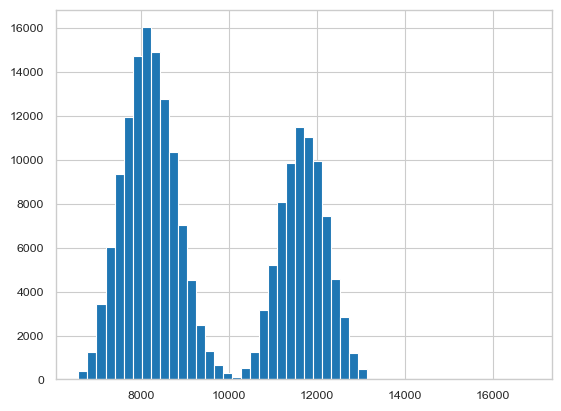

In [1161]:
meta_wag_param_f['lifespan'].hist(bins=50)
plt.show()

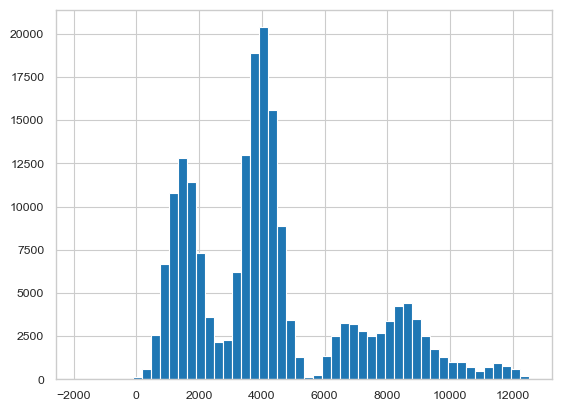

In [1162]:
meta_wag_param_f['lefttime'].hist(bins=50)
plt.show()

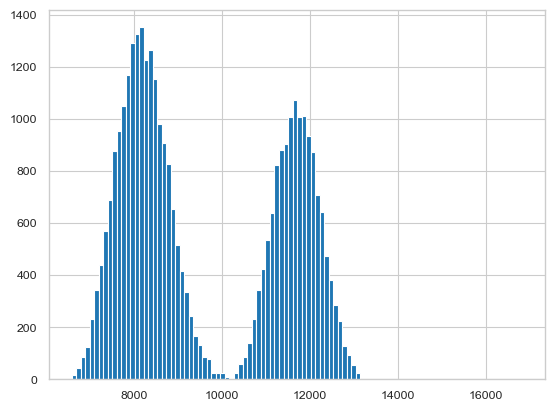

In [1163]:
wag_feb_param['lifespan'].hist(bins=100)
plt.show()

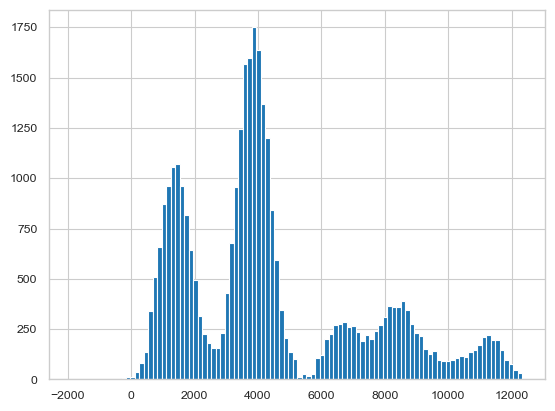

In [1164]:
wag_feb_param['lefttime'].hist(bins=100)
plt.show()

In [1089]:
wag_feb_param.drop(columns=['date_build', 'srok_sl', 'date_iskl', 'repdate', 'model'], inplace=True)
wag_feb_param.reset_index(drop=True, inplace=True)

In [1090]:
len(wag_feb_param)

33708

In [1091]:
wag_feb_param

,wagnum,ost_prob,manage_type,rod_id,reestr_state,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,lifespan,lefttime
0,0,42468,0,0,1,-10230,680,680,122.0,244,...,160,2,9,2,1,11,160000,0,11857,1036
1,1,83116,0,0,1,-9929,680,680,120.0,220,...,160,1,9,2,4,1,160000,0,11564,1130
2,2,50236,0,0,1,-2886,680,680,122.0,252,...,160,22,9,2,1,15,110000,0,11704,1383
3,3,52596,0,0,1,-3344,680,680,120.0,220,...,160,1,9,2,4,1,110000,0,11687,975
4,4,87594,0,0,1,-2626,680,680,120.0,235,...,160,2,9,3,6,1,160000,0,12478,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33703,33972,137520,0,1,1,-3939,700,700,77.0,235,...,160,2,9,3,1,12,160000,0,15576,3172
33704,33973,123914,0,1,1,-11842,700,700,77.0,235,...,160,2,9,2,1,12,160000,0,16408,3538
33705,33974,140696,0,1,1,-7507,700,700,77.0,235,...,160,2,9,2,1,12,160000,0,16231,3730
33706,33975,146264,0,1,1,-2396,700,700,77.0,235,...,160,2,9,2,1,12,160000,0,15972,3042


In [1096]:
#wag_feb_param.to_csv('wag_feb_param.csv')

## Обучение на датасете

In [1154]:
meta_wag_param_f = meta_wag_param.copy()

In [1155]:
meta_wag_param_f.drop(columns=['date_build', 'srok_sl', 'month', 'model'], inplace=True)
meta_wag_param_f.reset_index(drop=True, inplace=True)

In [1156]:
meta_wag_param_f.columns

Index(['wagnum', 'ost_prob', 'manage_type', 'rod_id', 'reestr_state',
       'target_month', 'target_day', 'prob_diff', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'zavod_build', 'cnsi_probeg_dr',
       'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz', 'tipvozd', 'tippogl',
       'norma_km', 'ownertype', 'lifespan', 'lefttime'],
      dtype='object')

In [1073]:
#meta_wag_param_f.to_csv('meta_wag_param_train.csv')

### Деление на выборки

wag_params	|	Данные по характеристикам вагона
| --- | --- |
wagnum	|Номер вагона
ownertype	|Признак передачи вагона в аренду (1-собст, 2-арендованный, 3-инвентарный)
model|	модель вагона. Соответствует справочнику Классификатор моделей грузовых вагонов
rod_id	|Тип РПС
gruz	|грузоподъемность (в центнерах)
cnsi_gruz_capacity|	Предельная грузоподъёмность
cnsi_volumek|	Объём кузова
tara	|Масса тары в центнерах
date_build	|дата постройки
srok_sl	|дата окончания срока службы
zavod_build	|завод постройки. Соответствует справочнику условных кодов предприятий IC00.VAG_UKP
cnsi_probeg_dr|	Норма пробега после ДР в тыс. км
cnsi_probeg_kr|	Норма пробега после КР в тыс. км
kuzov|	материал кузова
telega	|код модели тележки
tormoz	|Тип тормоза
tipvozd	|Тип воздухораспределителя
tippogl	|Тип поглощающего аппарата
norma_km	|Межремонтный норматив пробега (<> 0, если вагон на пробеге)
new_wagnum	|Новый номер вагона
oldnum	|Старый номер вагона


In [1157]:
meta_wag_param_f.dtypes

wagnum                         Int64
ost_prob                       Int64
manage_type                    Int64
rod_id                         Int64
reestr_state                   Int64
target_month                   Int64
target_day                     Int64
prob_diff                     object
gruz                           Int64
cnsi_gruz_capacity             Int64
cnsi_volumek                 Float64
tara                           Int64
zavod_build                    Int64
cnsi_probeg_dr                 Int64
cnsi_probeg_kr                 Int64
kuzov                          Int64
telega                         Int64
tormoz                         Int64
tipvozd               string[python]
tippogl                        Int64
norma_km                       Int64
ownertype                      Int64
lifespan                       int64
lefttime                       int64
dtype: object

In [1158]:
cat_features = ['manage_type', 'rod_id', 'reestr_state', 'tipvozd', 'ownertype', 'zavod_build', 'kuzov', 'telega', 'tormoz', 'tipvozd', 'tippogl', 'wagnum']

for cat in cat_features:
    meta_wag_param_f[cat] = meta_wag_param_f[cat].astype('str')

In [1159]:
    params = {
    'iterations': [100],
    'custom_loss': ['F1'],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 6, 9]
    }

for col in meta_wag_param_f.columns:
    print(meta_wag_param_f[col].value_counts())

0:	loss: 0.1366228	best: 0.1366228 (0)	total: 5.42s	remaining: 59.6s
1:	loss: 0.0795430	best: 0.0795430 (1)	total: 10.7s	remaining: 53.4s
2:	loss: 0.0784946	best: 0.0784946 (2)	total: 16s	remaining: 48.1s
3:	loss: 0.0777161	best: 0.0777161 (3)	total: 21.4s	remaining: 42.9s
4:	loss: 0.1295247	best: 0.0777161 (3)	total: 27.9s	remaining: 39.1s
5:	loss: 0.0772090	best: 0.0772090 (5)	total: 35.2s	remaining: 35.2s
6:	loss: 0.0767056	best: 0.0767056 (6)	total: 42.6s	remaining: 30.4s
7:	loss: 0.0772490	best: 0.0767056 (6)	total: 50.1s	remaining: 25s
8:	loss: 0.1255719	best: 0.0767056 (6)	total: 58.1s	remaining: 19.4s
9:	loss: 0.0775797	best: 0.0767056 (6)	total: 1m 8s	remaining: 13.7s
10:	loss: 0.0780285	best: 0.0767056 (6)	total: 1m 18s	remaining: 7.13s
11:	loss: 0.0774984	best: 0.0767056 (6)	total: 1m 29s	remaining: 0us
Estimating final quality...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.09352411357
bestIteration = 58

Training on fold [1/5]

bestTest = 0.0924175188
bestIteration = 94

Training on fold [2/5]

bestTest = 0.09003959645
bestIteration = 90

Training on fold [3/5]

bestTest = 0.09217494648
bestIteration = 84

Training on fold [4/5]

bestTest = 0.09515425577
bestIteration = 54

99    0.521732
Name: test-F1-mean, dtype: float64
0.5017160686427458


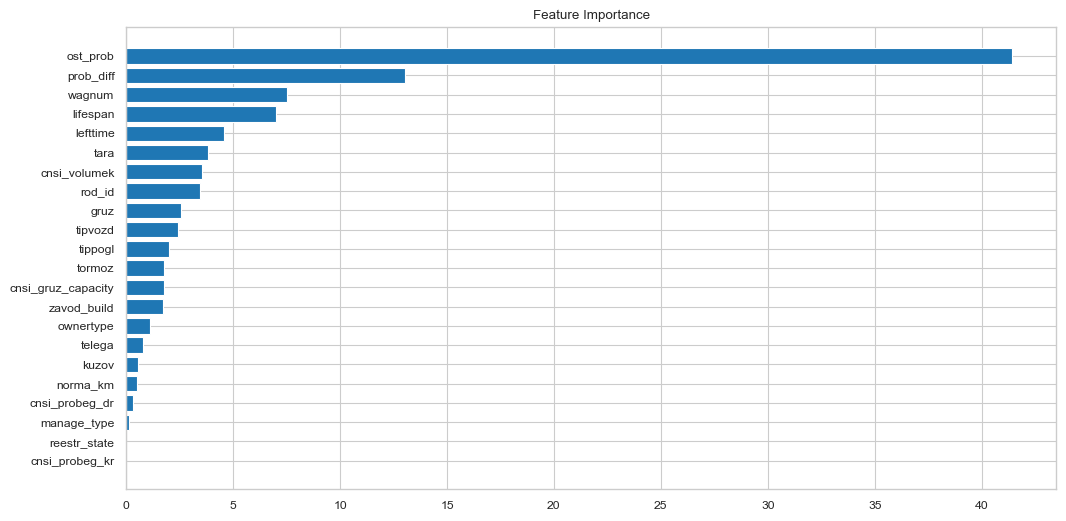

In [1160]:
trainer(meta_wag_param_f, cat_features, params)

0:	loss: 0.0770360	best: 0.0770360 (0)	total: 5.11s	remaining: 56.2s
1:	loss: 0.0497530	best: 0.0497530 (1)	total: 10.3s	remaining: 51.3s
2:	loss: 0.0496904	best: 0.0496904 (2)	total: 15.4s	remaining: 46.2s
3:	loss: 0.0498865	best: 0.0496904 (2)	total: 20.5s	remaining: 41.1s
4:	loss: 0.0666746	best: 0.0496904 (2)	total: 27.2s	remaining: 38.1s
5:	loss: 0.0499797	best: 0.0496904 (2)	total: 34s	remaining: 34s
6:	loss: 0.0497880	best: 0.0496904 (2)	total: 40.7s	remaining: 29.1s
7:	loss: 0.0498655	best: 0.0496904 (2)	total: 47.5s	remaining: 23.7s
8:	loss: 0.0676298	best: 0.0496904 (2)	total: 56.5s	remaining: 18.8s
9:	loss: 0.0499331	best: 0.0496904 (2)	total: 1m 5s	remaining: 13.1s
10:	loss: 0.0505040	best: 0.0496904 (2)	total: 1m 14s	remaining: 6.78s
11:	loss: 0.0503739	best: 0.0496904 (2)	total: 1m 23s	remaining: 0us
Estimating final quality...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.04541594062
bestIteration = 52

Training on fold [1/5]

bestTest = 0.04705634292
bestIteration = 59

Training on fold [2/5]

bestTest = 0.04703325888
bestIteration = 82

Training on fold [3/5]

bestTest = 0.04568675568
bestIteration = 61

Training on fold [4/5]

bestTest = 0.04657130134
bestIteration = 61

99    0.147905
Name: test-F1-mean, dtype: float64
0.2270531400966184


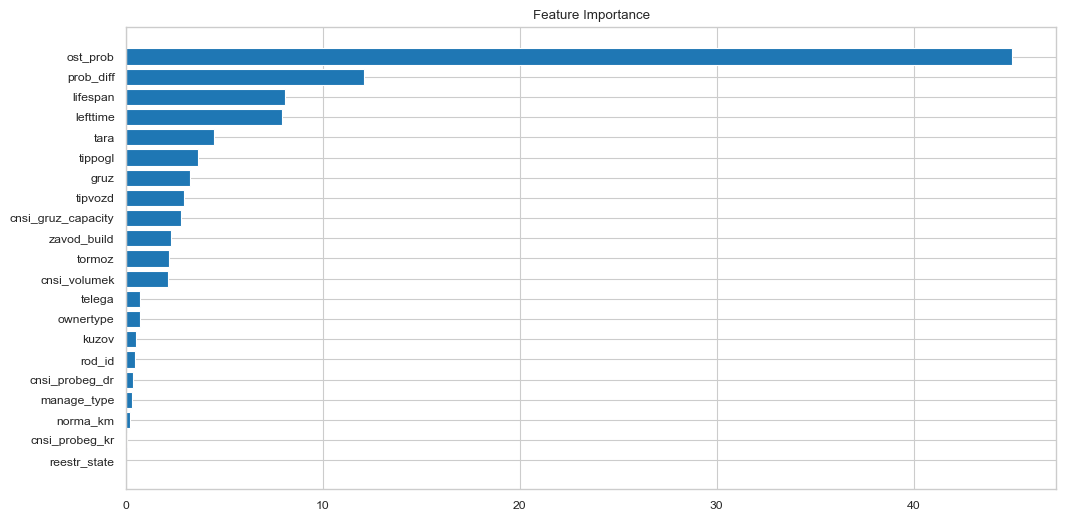

In [1102]:
trainer_d(meta_wag_param_f, cat_features, params)

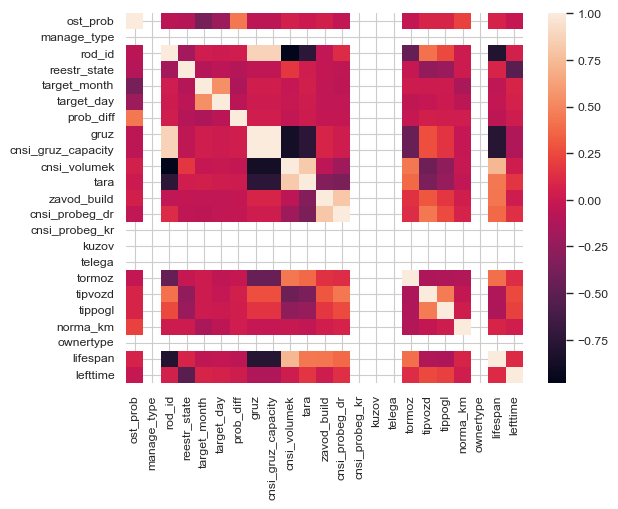

In [986]:
sns.heatmap(meta_wag_param_f.corr())
plt.show()

In [1165]:
score_month = 0.5017160686427458
score_day = 0.2270531400966184

In [1166]:
score = 0.5 * score_month + 0.5 * score_day

In [1167]:
score

0.36438460436968206

## Обучение на полной выборке для предикта за март

In [1103]:
meta_wag_param_f.head(2)

,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,...,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,lifespan,lefttime
0,52852,0,0,1,0,0,-4158,680,680,122.0,...,160,2,9,2,1,11,160000,0,11857,1067
1,93045,0,0,1,0,0,-24,680,680,120.0,...,160,1,9,2,4,1,160000,0,11564,1161


In [1104]:
features = meta_wag_param_f.drop(columns=['target_month', 'target_day'])
target_m = meta_wag_param_f['target_month']
target_d = meta_wag_param_f['target_day']

In [1105]:
cat_features = ['manage_type', 'rod_id', 'reestr_state', 'tipvozd', 'ownertype', 'zavod_build', 'kuzov',\
                'telega', 'tormoz', 'tipvozd', 'tippogl']

### Предсказание на месяц

In [1106]:
pool_train = Pool(features, label=target_m, cat_features=cat_features)

In [1107]:
params = {
    'iterations': [500],
    'custom_loss': ['F1'],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 6, 9]
}

In [1108]:
model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')

In [1109]:
gs = model.grid_search(params, X=pool_train)

0:	loss: 0.0967091	best: 0.0967091 (0)	total: 36s	remaining: 6m 35s
1:	loss: 0.0949427	best: 0.0949427 (1)	total: 1m 14s	remaining: 6m 10s
2:	loss: 0.0951966	best: 0.0949427 (1)	total: 1m 53s	remaining: 5m 40s
3:	loss: 0.0955425	best: 0.0949427 (1)	total: 2m 33s	remaining: 5m 7s
4:	loss: 0.0953735	best: 0.0949427 (1)	total: 3m 36s	remaining: 5m 2s
5:	loss: 0.0948052	best: 0.0948052 (5)	total: 4m 41s	remaining: 4m 41s
6:	loss: 0.0946889	best: 0.0946889 (6)	total: 5m 47s	remaining: 4m 7s
7:	loss: 0.0949382	best: 0.0946889 (6)	total: 6m 53s	remaining: 3m 26s
8:	loss: 0.0949849	best: 0.0946889 (6)	total: 8m 22s	remaining: 2m 47s
9:	loss: 0.0950203	best: 0.0946889 (6)	total: 9m 57s	remaining: 1m 59s
10:	loss: 0.0949600	best: 0.0946889 (6)	total: 11m 34s	remaining: 1m 3s
11:	loss: 0.0952234	best: 0.0946889 (6)	total: 13m 10s	remaining: 0us
Estimating final quality...


In [1110]:
gs['params']

{'depth': 6, 'iterations': 500, 'learning_rate': 0.2, 'custom_metric': 'F1'}

In [1112]:
model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=1000,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.2,
    depth=6,                    
    verbose=False)

In [1113]:
model.fit(features, target_m)

In [1114]:
features_test = wag_feb_param.copy()


In [1115]:
features_test.isna().sum()

wagnum                   0
ost_prob              1022
manage_type              0
rod_id                   0
reestr_state             0
prob_diff             1175
gruz                     0
cnsi_gruz_capacity       0
cnsi_volumek             0
tara                     0
zavod_build              0
cnsi_probeg_dr           0
cnsi_probeg_kr           0
kuzov                    0
telega                   0
tormoz                   0
tipvozd                  0
tippogl                 59
norma_km                 0
ownertype                0
lifespan                 0
lefttime                 0
dtype: int64

In [1116]:
features_test['ost_prob'] = features_test['ost_prob'].fillna(features_test['ost_prob'].median())

In [1117]:
features_test['prob_diff'] = features_test['prob_diff'].fillna(features_test['prob_diff'].median())

In [1118]:
features_test['tippogl'].mode()

0    11
Name: tippogl, dtype: Int64

In [1119]:
features_test['tippogl'] = features_test['tippogl'].fillna(11)

In [1120]:
features_test.isna().sum()

wagnum                0
ost_prob              0
manage_type           0
rod_id                0
reestr_state          0
prob_diff             0
gruz                  0
cnsi_gruz_capacity    0
cnsi_volumek          0
tara                  0
zavod_build           0
cnsi_probeg_dr        0
cnsi_probeg_kr        0
kuzov                 0
telega                0
tormoz                0
tipvozd               0
tippogl               0
norma_km              0
ownertype             0
lifespan              0
lefttime              0
dtype: int64

In [1121]:
pred = model.predict(features_test)

In [1122]:
pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [1123]:
features_test['pred'] = pred

In [1124]:
features_test.head()

,wagnum,ost_prob,manage_type,rod_id,reestr_state,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,lifespan,lefttime,pred
0,0,42468,0,0,1,-10230.0,680,680,122.0,244,...,2,9,2,1,11,160000,0,11857,1036,0
1,1,83116,0,0,1,-9929.0,680,680,120.0,220,...,1,9,2,4,1,160000,0,11564,1130,0
2,2,50236,0,0,1,-2886.0,680,680,122.0,252,...,22,9,2,1,15,110000,0,11704,1383,0
3,3,52596,0,0,1,-3344.0,680,680,120.0,220,...,1,9,2,4,1,110000,0,11687,975,0
4,4,87594,0,0,1,-2626.0,680,680,120.0,235,...,2,9,3,6,1,160000,0,12478,2008,0


In [1023]:
sub = pd.read_csv(path_train + '/target/y_predict_submit_example.csv')

In [1024]:
sub.head()

,wagnum,month,target_month,target_day
0,33361,2023-03-01,1,1
1,33364,2023-03-01,1,1
2,33366,2023-03-01,1,1
3,33358,2023-03-01,1,1
4,33349,2023-03-01,1,1


In [1025]:
len(sub)

33707

In [ ]:
new_sub

In [1126]:
new_sub = sub.merge(features_test[['pred', 'wagnum']], how='left', on='wagnum')

In [1143]:
new_sub.head()

,wagnum,month,target_month,target_day,pred_day
0,33361,2023-03-01,1,1,0
1,33364,2023-03-01,1,1,0
2,33366,2023-03-01,1,1,0
3,33358,2023-03-01,1,1,0
4,33349,2023-03-01,1,1,0


In [1133]:
new_sub.isna().sum()

wagnum          0
month           0
target_month    0
target_day      0
pred            0
dtype: int64

In [1127]:
len(new_sub)

33707

### Предсказание на 10 дней 

In [1129]:
pool_train = Pool(features, label=target_d, cat_features=cat_features)

In [1130]:
params = {
    'iterations': [500],
    'custom_loss': ['F1'],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 6, 9]
}

In [1131]:
model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')

In [1132]:
gs = model.grid_search(params, X=pool_train)

0:	loss: 0.0474080	best: 0.0474080 (0)	total: 37.4s	remaining: 6m 51s
1:	loss: 0.0470645	best: 0.0470645 (1)	total: 1m 17s	remaining: 6m 27s
2:	loss: 0.0471307	best: 0.0470645 (1)	total: 1m 58s	remaining: 5m 56s
3:	loss: 0.0472713	best: 0.0470645 (1)	total: 2m 40s	remaining: 5m 20s
4:	loss: 0.0470712	best: 0.0470645 (1)	total: 3m 42s	remaining: 5m 11s
5:	loss: 0.0471614	best: 0.0470645 (1)	total: 4m 47s	remaining: 4m 47s
6:	loss: 0.0473740	best: 0.0470645 (1)	total: 5m 53s	remaining: 4m 12s
7:	loss: 0.0471473	best: 0.0470645 (1)	total: 7m 2s	remaining: 3m 31s
8:	loss: 0.0470088	best: 0.0470088 (8)	total: 8m 31s	remaining: 2m 50s
9:	loss: 0.0472646	best: 0.0470088 (8)	total: 10m 10s	remaining: 2m 2s
10:	loss: 0.0472833	best: 0.0470088 (8)	total: 11m 46s	remaining: 1m 4s
11:	loss: 0.0477312	best: 0.0470088 (8)	total: 13m 22s	remaining: 0us
Estimating final quality...


In [1134]:
gs['params']

{'depth': 9, 'iterations': 500, 'learning_rate': 0.01, 'custom_metric': 'F1'}

In [1135]:
model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=1000,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.01,
    depth=9,                    
    verbose=False)

In [1137]:
pred_day = model.predict(features_test)

In [1138]:
pred_day

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [1139]:
features_test['pred_day'] = pred_day

In [1140]:
features_test.head()

,wagnum,ost_prob,manage_type,rod_id,reestr_state,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,lifespan,lefttime,pred,pred_day
0,0,42468,0,0,1,-10230.0,680,680,122.0,244,...,9,2,1,11,160000,0,11857,1036,0,0
1,1,83116,0,0,1,-9929.0,680,680,120.0,220,...,9,2,4,1,160000,0,11564,1130,0,0
2,2,50236,0,0,1,-2886.0,680,680,122.0,252,...,9,2,1,15,110000,0,11704,1383,0,0
3,3,52596,0,0,1,-3344.0,680,680,120.0,220,...,9,2,4,1,110000,0,11687,975,0,0
4,4,87594,0,0,1,-2626.0,680,680,120.0,235,...,9,3,6,1,160000,0,12478,2008,0,0


In [1144]:
new_sub = sub.merge(features_test[['pred_day', 'wagnum', 'pred']], how='left', on='wagnum')

In [1145]:
new_sub.head()

,wagnum,month,target_month,target_day,pred_day,pred
0,33361,2023-03-01,1,1,0,0
1,33364,2023-03-01,1,1,0,0
2,33366,2023-03-01,1,1,0,0
3,33358,2023-03-01,1,1,0,0
4,33349,2023-03-01,1,1,0,0


In [1146]:
new_sub.drop(columns=['target_month', 'target_day'], inplace=True)

In [1148]:
new_sub = new_sub.rename(columns={"pred": "target_month"})

In [1149]:
new_sub = new_sub.rename(columns={"pred_day": "target_day"})

In [1150]:
new_sub

,wagnum,month,target_day,target_month
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [1151]:
submission = new_sub[['wagnum', 'month', 'target_month', 'target_day']].copy()

In [1153]:
submission.to_csv('submission.csv')

## Датасет 2 

In [1274]:
meta_wag_param['target_month'].sum()

9570

In [1269]:
list_kti = kti['wagnum'].unique()

In [1275]:
len(list_kti)

6686

In [1270]:
list_rem = tr_rem['wagnum'].unique()

In [1273]:
list_kti.isin(list_rem).sum()

3970

tr_rem|	Данные по текущим ремонтам вагона
|----|----|
wagnum	|Номер вагона
rem_month	|Дата ремонта
kod_vrab|	Код работ
neis1_kod	|Код неисправности 1 (Заполняется по с.5353)
neis2_kod	|Код неисправности 2 (Заполняется по с.5353)
neis3_kod|	Код неисправности 3 (Заполняется по с.5353)
mod1_kod	|Код модернизации 1 (Заполняется по с.5354)
mod2_kod|	Код модернизации 2 (Заполняется по с.5354)
mod3_kod	|Код модернизации 3 (Заполняется по с.5354)
mod4_kod	|Код модернизации 4 (Заполняется по с.5354)
mod5_kod	|Код модернизации 5 (Заполняется по с.5354)
mod6_kod	|Код модернизации 6 (Заполняется по с.5354)
mod7_kod	|Код модернизации 7 (Заполняется по с.5354)
st_id_send	|Код станции перевода вагона в неисправные (nsi_db.station.ST_CODE)
road_id_send	|ID дороги перевода вагона в неисправные(nsi_db.railway.RW_ID)
gr_probeg	|Пробег вагона в груженом состоянии


In [1251]:
len(tr_rem['wagnum'].unique())

19621

In [1253]:
tr_rem_clean = tr_rem.drop_duplicates(subset=['wagnum', 'rem_month'], keep='last')

In [1254]:
len(tr_rem_clean['wagnum'].unique())

19621

In [1255]:
tr_rem_clean.shape[0]

28567

In [1256]:
rem_count = tr_rem.groupby('wagnum')['wagnum'].agg('count').to_frame().rename(columns={"wagnum": "rem_count"}).reset_index()

In [1257]:
rem_count

,wagnum,rem_count
0,0,2
1,2,4
2,3,2
3,5,2
4,6,10
...,...,...
19616,33963,2
19617,33969,2
19618,33973,2
19619,33975,2


In [1258]:
tr_rem_clean = tr_rem_clean.merge(rem_count, how='left', on='wagnum')

In [1259]:
tr_rem_clean

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send,rem_count
0,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,38,87913,37467,10441,2
1,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,28,81824,45579,4789,6
2,13674,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,28,64130,34697,4789,6
3,1145,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,3,89735,39549,392,2
4,2430,2022-08-01,3,2,98,54,7,4,2,0,0,0,0,25,68986,26528,12611,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28562,19485,2023-02-01,3,6,98,54,7,4,2,0,0,0,0,40,83707,33694,10694,2
28563,5300,2023-02-01,3,6,98,54,7,4,2,0,0,0,0,42,23945,10147,11464,1
28564,13550,2023-02-01,3,0,98,54,1,4,2,0,0,0,0,16,92068,38886,4421,2
28565,33743,2023-02-01,2,31,98,54,7,4,2,0,0,0,0,28,16408,7664,6321,2


In [1261]:
meta_wag_param

,wagnum,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,month,model,...,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype,lifespan,lefttime
0,0,52852,0,0,1,0,0,-4158,2023-01-01,11-276,...,160,2,9,2,1,11,160000,0,11857,1067
1,1,93045,0,0,1,0,0,-24,2023-01-01,11-066-04,...,160,1,9,2,4,1,160000,0,11564,1161
2,2,53122,0,0,1,0,0,-3014,2023-01-01,Р-9494-01,...,160,22,9,2,1,15,110000,0,11704,1414
3,3,55940,0,0,1,0,0,-11058,2023-01-01,11-066-04,...,160,1,9,2,4,1,110000,0,11687,1006
4,4,90612,0,0,1,0,0,-7261,2023-01-01,11-217,...,160,2,9,3,6,1,160000,0,12478,2039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194617,33972,2463,0,1,1,0,0,-3454,2022-08-01,12-532-02,...,160,2,9,3,1,12,160000,0,15576,3356
194618,33973,3312,0,1,1,1,0,-6056,2022-08-01,12-532-02,...,160,2,9,2,1,12,160000,0,16408,3722
194619,33974,30853,0,1,1,0,0,-7067,2022-08-01,12-532-02,...,160,2,9,2,1,12,160000,0,16231,3914
194620,33975,6580,0,1,1,0,0,-7683,2022-08-01,12-532-02,...,160,2,9,2,1,12,160000,0,15972,3226


In [1262]:
meta_wag_tr_rem = meta_wag_param.merge(tr_rem_clean, how='left', left_on=['wagnum', 'month'], right_on=['wagnum', 'rem_month'])

In [1278]:
meta_wag_tr_rem.drop(columns=['rem_month'], inplace=True)

In [1279]:
meta_wag_tr_rem.isna().sum()

wagnum                     0
ost_prob                   0
manage_type                0
rod_id                     0
reestr_state               0
target_month               0
target_day                 0
prob_diff                  0
month                      0
model                      0
gruz                       0
cnsi_gruz_capacity         0
cnsi_volumek               0
tara                       0
date_build                 0
srok_sl                    0
zavod_build                0
cnsi_probeg_dr             0
cnsi_probeg_kr             0
kuzov                      0
telega                     0
tormoz                     0
tipvozd                    0
tippogl                    0
norma_km                   0
ownertype                  0
lifespan                   0
lefttime                   0
kod_vrab              170903
neis1_kod             170903
neis2_kod             170903
neis3_kod             170903
mod1_kod              170903
mod2_kod              170903
mod3_kod      

In [1265]:
meta_wag_tr_rem['rem_count'] = meta_wag_tr_rem['rem_count'].fillna(0)

In [1276]:
meta_wag_tr_rem['por_probeg'] = meta_wag_tr_rem['por_probeg'].fillna(0)

In [1277]:
meta_wag_tr_rem['gr_probeg'] = meta_wag_tr_rem['gr_probeg'].fillna(0)

In [1282]:
cat_meta = ['kod_vrab', 'neis1_kod', 'neis2_kod', 'neis3_kod',
       'mod1_kod', 'mod2_kod', 'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod',
       'mod7_kod', 'road_id_send', 'st_id_send']

In [1284]:
for x in cat_meta:
    meta_wag_tr_rem[x] = meta_wag_tr_rem[x].astype('string')

In [1285]:
meta_wag_tr_rem.fillna('no_data', inplace=True)

In [1286]:
meta_wag_tr_rem

,wagnum,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,month,model,...,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send,rem_count
0,0,52852,0,0,1,0,0,-4158,2023-01-01 00:00:00,11-276,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
1,1,93045,0,0,1,0,0,-24,2023-01-01 00:00:00,11-066-04,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
2,2,53122,0,0,1,0,0,-3014,2023-01-01 00:00:00,Р-9494-01,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
3,3,55940,0,0,1,0,0,-11058,2023-01-01 00:00:00,11-066-04,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
4,4,90612,0,0,1,0,0,-7261,2023-01-01 00:00:00,11-217,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194617,33972,2463,0,1,1,0,0,-3454,2022-08-01 00:00:00,12-532-02,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
194618,33973,3312,0,1,1,1,0,-6056,2022-08-01 00:00:00,12-532-02,...,2,0,0,0,0,16,84952,67549,4247,2.0
194619,33974,30853,0,1,1,0,0,-7067,2022-08-01 00:00:00,12-532-02,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
194620,33975,6580,0,1,1,0,0,-7683,2022-08-01 00:00:00,12-532-02,...,2,0,0,0,0,3,97459,49937,385,2.0


### Фичи для февраля

In [1315]:
tr_rem_clean_feb = tr_rem_clean[tr_rem_clean['rem_month'] == '2023-02-01']

In [1317]:
wag_feb_tr_rem = wag_feb_param.merge(tr_rem_clean_feb, how='left', on='wagnum')

In [1319]:
wag_feb_tr_rem.drop(columns=['rem_month'], inplace=True)

In [1320]:
wag_feb_tr_rem.isna().sum()

wagnum                    0
ost_prob               1022
manage_type               0
rod_id                    0
reestr_state              0
prob_diff              1175
gruz                      0
cnsi_gruz_capacity        0
cnsi_volumek              0
tara                      0
zavod_build               0
cnsi_probeg_dr            0
cnsi_probeg_kr            0
kuzov                     0
telega                    0
tormoz                    0
tipvozd                   0
tippogl                  59
norma_km                  0
ownertype                 0
lifespan                  0
lefttime                  0
kod_vrab              29786
neis1_kod             29786
neis2_kod             29786
neis3_kod             29786
mod1_kod              29786
mod2_kod              29786
mod3_kod              29786
mod4_kod              29786
mod5_kod              29786
mod6_kod              29786
mod7_kod              29786
road_id_send          29786
gr_probeg             29820
por_probeg          

In [1321]:
wag_feb_tr_rem['rem_count'] = wag_feb_tr_rem['rem_count'].fillna(0)

In [1322]:
wag_feb_tr_rem['por_probeg'] = wag_feb_tr_rem['por_probeg'].fillna(0)

In [1323]:
wag_feb_tr_rem['gr_probeg'] = wag_feb_tr_rem['gr_probeg'].fillna(0)

In [1324]:
wag_feb_tr_rem['ost_prob'] = wag_feb_tr_rem['ost_prob'].fillna(wag_feb_tr_rem['ost_prob'].median())
wag_feb_tr_rem['prob_diff'] = wag_feb_tr_rem['prob_diff'].fillna(wag_feb_tr_rem['prob_diff'].median())

In [1328]:
cat_meta = ['kod_vrab', 'neis1_kod', 'neis2_kod', 'neis3_kod',
       'mod1_kod', 'mod2_kod', 'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod',
       'mod7_kod', 'road_id_send', 'st_id_send', 'tippogl']

In [1329]:
for x in cat_meta:
    wag_feb_tr_rem[x] = wag_feb_tr_rem[x].astype('string')

In [1330]:
wag_feb_tr_rem.fillna('no_data', inplace=True)

In [1332]:
#wag_feb_tr_rem.to_csv('wag_feb_v2.csv')

### Валидация модели на данном датасете

In [1287]:
meta_wag_param_f = meta_wag_tr_rem.copy()

In [1288]:
meta_wag_param_f.drop(columns=['date_build', 'srok_sl', 'month', 'model'], inplace=True)
meta_wag_param_f.reset_index(drop=True, inplace=True)

In [1289]:
meta_wag_param_f.columns

Index(['wagnum', 'ost_prob', 'manage_type', 'rod_id', 'reestr_state',
       'target_month', 'target_day', 'prob_diff', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'zavod_build', 'cnsi_probeg_dr',
       'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz', 'tipvozd', 'tippogl',
       'norma_km', 'ownertype', 'lifespan', 'lefttime', 'kod_vrab',
       'neis1_kod', 'neis2_kod', 'neis3_kod', 'mod1_kod', 'mod2_kod',
       'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod', 'mod7_kod',
       'road_id_send', 'gr_probeg', 'por_probeg', 'st_id_send', 'rem_count'],
      dtype='object')

In [1311]:
#meta_wag_param_f.to_csv('meta_wag_param_train_v2.csv')

#### Деление на выборки

In [1290]:
meta_wag_param_f.dtypes

wagnum                         Int64
ost_prob                       Int64
manage_type                    Int64
rod_id                         Int64
reestr_state                   Int64
target_month                   Int64
target_day                     Int64
prob_diff                     object
gruz                           Int64
cnsi_gruz_capacity             Int64
cnsi_volumek                 Float64
tara                           Int64
zavod_build                    Int64
cnsi_probeg_dr                 Int64
cnsi_probeg_kr                 Int64
kuzov                          Int64
telega                         Int64
tormoz                         Int64
tipvozd               string[python]
tippogl                        Int64
norma_km                       Int64
ownertype                      Int64
lifespan                       int64
lefttime                       int64
kod_vrab              string[python]
neis1_kod             string[python]
neis2_kod             string[python]
n

In [1299]:
cat_features = ['manage_type', 'rod_id', 'reestr_state', 'tipvozd', 'ownertype', 'zavod_build', 'kuzov', 'telega', 'tormoz', 'tipvozd',\
                'tippogl', 'wagnum', 'kod_vrab', 'neis1_kod', 'neis2_kod', 'neis3_kod',
       'mod1_kod', 'mod2_kod', 'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod',
       'mod7_kod', 'road_id_send', 'st_id_send']

In [1295]:
text_features = ['kod_vrab', 'neis1_kod', 'neis2_kod', 'neis3_kod',
       'mod1_kod', 'mod2_kod', 'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod',
       'mod7_kod', 'road_id_send', 'st_id_send']

In [1303]:
    params = {
    'iterations': [100],
    'custom_loss': ['F1'],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 6, 9]
    }

0:	loss: 0.1377509	best: 0.1377509 (0)	total: 7.33s	remaining: 1m 20s
1:	loss: 0.0796473	best: 0.0796473 (1)	total: 14.9s	remaining: 1m 14s
2:	loss: 0.0782601	best: 0.0782601 (2)	total: 22.5s	remaining: 1m 7s
3:	loss: 0.0780975	best: 0.0780975 (3)	total: 30.1s	remaining: 1m
4:	loss: 0.1326796	best: 0.0780975 (3)	total: 39.3s	remaining: 55.1s
5:	loss: 0.0779140	best: 0.0779140 (5)	total: 49.7s	remaining: 49.7s
6:	loss: 0.0773869	best: 0.0773869 (6)	total: 1m	remaining: 42.9s
7:	loss: 0.0775500	best: 0.0773869 (6)	total: 1m 10s	remaining: 35.1s
8:	loss: 0.1299302	best: 0.0773869 (6)	total: 1m 20s	remaining: 26.8s
9:	loss: 0.0776396	best: 0.0773869 (6)	total: 1m 33s	remaining: 18.7s
10:	loss: 0.0774727	best: 0.0773869 (6)	total: 1m 46s	remaining: 9.68s
11:	loss: 0.0784334	best: 0.0773869 (6)	total: 2m	remaining: 0us
Estimating final quality...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.0757501252
bestIteration = 60

Training on fold [1/5]

bestTest = 0.07440104748
bestIteration = 69

Training on fold [2/5]

bestTest = 0.07319064173
bestIteration = 74

Training on fold [3/5]

bestTest = 0.0729687827
bestIteration = 88

Training on fold [4/5]

bestTest = 0.07667853972
bestIteration = 75

99    0.65464
Name: test-F1-mean, dtype: float64
0.7584359935725763


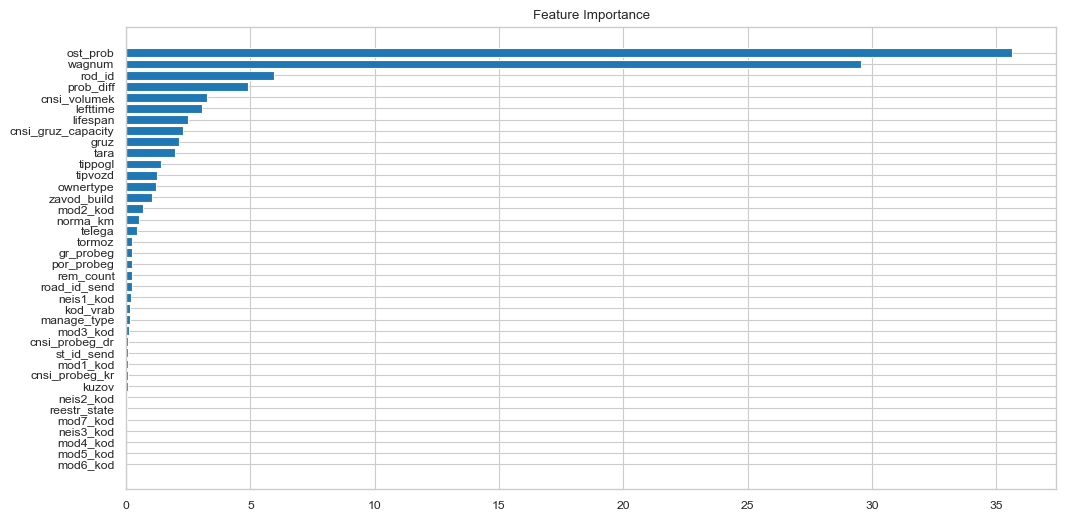

In [1304]:
trainer(meta_wag_param_f, cat_features, params)

0:	loss: 0.0805340	best: 0.0805340 (0)	total: 8.74s	remaining: 1m 36s
1:	loss: 0.0489111	best: 0.0489111 (1)	total: 17.1s	remaining: 1m 25s
2:	loss: 0.0487656	best: 0.0487656 (2)	total: 25.3s	remaining: 1m 15s
3:	loss: 0.0490107	best: 0.0487656 (2)	total: 33.5s	remaining: 1m 7s
4:	loss: 0.0782279	best: 0.0487656 (2)	total: 42.6s	remaining: 59.6s
5:	loss: 0.0487819	best: 0.0487656 (2)	total: 52.9s	remaining: 52.9s
6:	loss: 0.0487014	best: 0.0487014 (6)	total: 1m 4s	remaining: 46s
7:	loss: 0.0488830	best: 0.0487014 (6)	total: 1m 15s	remaining: 37.7s
8:	loss: 0.0781460	best: 0.0487014 (6)	total: 1m 24s	remaining: 28.3s
9:	loss: 0.0490365	best: 0.0487014 (6)	total: 1m 37s	remaining: 19.5s
10:	loss: 0.0489312	best: 0.0487014 (6)	total: 1m 51s	remaining: 10.1s
11:	loss: 0.0490778	best: 0.0487014 (6)	total: 2m 5s	remaining: 0us
Estimating final quality...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.04503843327
bestIteration = 33

Training on fold [1/5]

bestTest = 0.04602724564
bestIteration = 27

Training on fold [2/5]

bestTest = 0.04585273131
bestIteration = 50

Training on fold [3/5]

bestTest = 0.0448365142
bestIteration = 58

Training on fold [4/5]

bestTest = 0.04604186361
bestIteration = 60

99    0.181835
Name: test-F1-mean, dtype: float64
0.27608695652173915


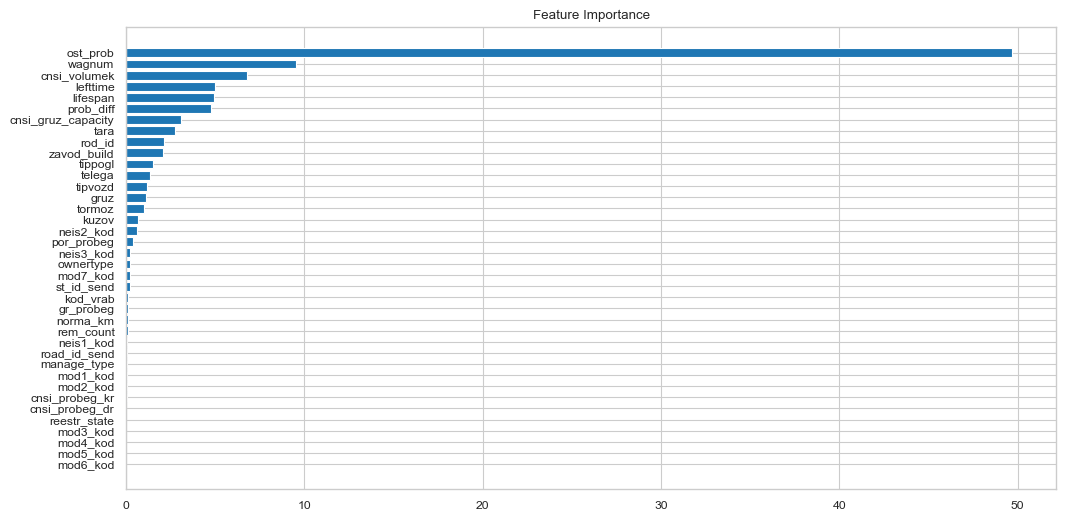

In [1306]:
trainer_d(meta_wag_param_f, cat_features, params)

In [1308]:
score_month = 0.7584359935725763
score_day = 0.27608695652173915

In [1309]:
score = 0.5 * score_month + 0.5 * score_day

In [1310]:
score

0.5172614750471577

## Обучение на полной выборке для предикта за март

In [1333]:
meta_wag_param_f.head(2)

,wagnum,ost_prob,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,gruz,cnsi_gruz_capacity,...,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send,rem_count
0,0,52852,0,0,1,0,0,-4158,680,680,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0
1,1,93045,0,0,1,0,0,-24,680,680,...,no_data,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0


In [1334]:
features = meta_wag_param_f.drop(columns=['target_month', 'target_day'])
target_m = meta_wag_param_f['target_month']
target_d = meta_wag_param_f['target_day']

In [1335]:
cat_features = ['manage_type', 'rod_id', 'reestr_state', 'tipvozd', 'ownertype', 'zavod_build', 'kuzov', 'telega', 'tormoz', 'tipvozd',\
                'tippogl', 'wagnum', 'kod_vrab', 'neis1_kod', 'neis2_kod', 'neis3_kod',
       'mod1_kod', 'mod2_kod', 'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod',
       'mod7_kod', 'road_id_send', 'st_id_send']

### Предсказание на месяц

In [1336]:
pool_train = Pool(features, label=target_m, cat_features=cat_features)

In [1337]:
params = {
    'iterations': [500],
    'custom_loss': ['F1'],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 6, 9]
}

In [1338]:
model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')

In [1339]:
gs = model.grid_search(params, X=pool_train)

0:	loss: 0.0676005	best: 0.0676005 (0)	total: 1m 16s	remaining: 14m 1s
1:	loss: 0.0603116	best: 0.0603116 (1)	total: 2m 33s	remaining: 12m 49s
2:	loss: 0.0597436	best: 0.0597436 (2)	total: 3m 52s	remaining: 11m 37s
3:	loss: 0.0595215	best: 0.0595215 (3)	total: 5m 10s	remaining: 10m 20s
4:	loss: 0.0595075	best: 0.0595075 (4)	total: 7m 38s	remaining: 10m 41s
5:	loss: 0.0551954	best: 0.0551954 (5)	total: 9m 57s	remaining: 9m 57s
6:	loss: 0.0537312	best: 0.0537312 (6)	total: 12m 14s	remaining: 8m 44s
7:	loss: 0.0562798	best: 0.0537312 (6)	total: 14m 29s	remaining: 7m 14s
8:	loss: 0.0562124	best: 0.0537312 (6)	total: 18m 3s	remaining: 6m 1s
9:	loss: 0.0526655	best: 0.0526655 (9)	total: 21m 28s	remaining: 4m 17s
10:	loss: 0.0535224	best: 0.0526655 (9)	total: 24m 58s	remaining: 2m 16s
11:	loss: 0.0553959	best: 0.0526655 (9)	total: 28m 26s	remaining: 0us
Estimating final quality...


In [1341]:
gs['params']

{'depth': 9, 'iterations': 500, 'learning_rate': 0.1, 'custom_metric': 'F1'}

In [1344]:
model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=1000,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.1,
    depth=9,                    
    verbose=False,
    cat_features=cat_features)

In [1345]:
model.fit(features, target_m)

In [1346]:
features_test = wag_feb_tr_rem.copy()


In [1347]:
features_test.isna().sum()

wagnum                0
ost_prob              0
manage_type           0
rod_id                0
reestr_state          0
prob_diff             0
gruz                  0
cnsi_gruz_capacity    0
cnsi_volumek          0
tara                  0
zavod_build           0
cnsi_probeg_dr        0
cnsi_probeg_kr        0
kuzov                 0
telega                0
tormoz                0
tipvozd               0
tippogl               0
norma_km              0
ownertype             0
lifespan              0
lefttime              0
kod_vrab              0
neis1_kod             0
neis2_kod             0
neis3_kod             0
mod1_kod              0
mod2_kod              0
mod3_kod              0
mod4_kod              0
mod5_kod              0
mod6_kod              0
mod7_kod              0
road_id_send          0
gr_probeg             0
por_probeg            0
st_id_send            0
rem_count             0
dtype: int64

In [1349]:
pred = model.predict(features_test)

In [1351]:
features_test['pred'] = pred

In [1352]:
features_test.head()

,wagnum,ost_prob,manage_type,rod_id,reestr_state,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send,rem_count,pred
0,0,42468,0,0,1,-10230.0,680,680,122.0,244,...,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0
1,1,83116,0,0,1,-9929.0,680,680,120.0,220,...,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0
2,2,50236,0,0,1,-2886.0,680,680,122.0,252,...,0,0,0,0,38,44498,15230,10150,4.0,0
3,3,52596,0,0,1,-3344.0,680,680,120.0,220,...,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0
4,4,87594,0,0,1,-2626.0,680,680,120.0,235,...,no_data,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0


In [1354]:
sub = pd.read_csv(path_train + '/target/y_predict_submit_example.csv')

In [1355]:
sub.head()

,wagnum,month,target_month,target_day
0,33361,2023-03-01,1,1
1,33364,2023-03-01,1,1
2,33366,2023-03-01,1,1
3,33358,2023-03-01,1,1
4,33349,2023-03-01,1,1


In [1356]:
len(sub)

33707

In [1357]:
new_sub = sub.merge(features_test[['pred', 'wagnum']], how='left', on='wagnum')

In [1358]:
new_sub.head()

,wagnum,month,target_month,target_day,pred
0,33361,2023-03-01,1,1,0
1,33364,2023-03-01,1,1,0
2,33366,2023-03-01,1,1,0
3,33358,2023-03-01,1,1,0
4,33349,2023-03-01,1,1,0


In [1359]:
new_sub.isna().sum()

wagnum          0
month           0
target_month    0
target_day      0
pred            0
dtype: int64

In [1360]:
len(new_sub)

33707

### Предсказание на 10 дней 

In [1361]:
pool_train = Pool(features, label=target_d, cat_features=cat_features)

In [1362]:
params = {
    'iterations': [100],
    'custom_loss': ['F1'],
    'learning_rate': [0.1],
    'depth': [3, 6, 9]
}

In [1363]:
model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')

In [1364]:
gs = model.grid_search(params, X=pool_train)

0:	loss: 0.0462188	best: 0.0462188 (0)	total: 6.58s	remaining: 13.2s
1:	loss: 0.0460114	best: 0.0460114 (1)	total: 15.3s	remaining: 7.66s
2:	loss: 0.0460885	best: 0.0460114 (1)	total: 27.9s	remaining: 0us
Estimating final quality...


In [1365]:
gs['params']

{'depth': 6, 'iterations': 100, 'learning_rate': 0.1, 'custom_metric': 'F1'}

In [1366]:
model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=1000,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.1,
    depth=6,                    
    verbose=False,
    cat_features=cat_features)

In [1368]:
model.fit(features, target_d)

In [1369]:
pred_day = model.predict(features_test)

In [1373]:
(pred_day > 0).sum()

181

In [1371]:
features_test['pred_day'] = pred_day

In [1372]:
features_test.head()

,wagnum,ost_prob,manage_type,rod_id,reestr_state,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send,rem_count,pred,pred_day
0,0,42468,0,0,1,-10230.0,680,680,122.0,244,...,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0,0
1,1,83116,0,0,1,-9929.0,680,680,120.0,220,...,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0,0
2,2,50236,0,0,1,-2886.0,680,680,122.0,252,...,0,0,0,38,44498,15230,10150,4.0,0,0
3,3,52596,0,0,1,-3344.0,680,680,120.0,220,...,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0,0
4,4,87594,0,0,1,-2626.0,680,680,120.0,235,...,no_data,no_data,no_data,no_data,0,0,no_data,0.0,0,0


In [1374]:
new_sub = sub.merge(features_test[['pred_day', 'wagnum', 'pred']], how='left', on='wagnum')

In [1375]:
new_sub.head()

,wagnum,month,target_month,target_day,pred_day,pred
0,33361,2023-03-01,1,1,0,0
1,33364,2023-03-01,1,1,0,0
2,33366,2023-03-01,1,1,0,0
3,33358,2023-03-01,1,1,0,0
4,33349,2023-03-01,1,1,0,0


In [1376]:
new_sub.drop(columns=['target_month', 'target_day'], inplace=True)

In [1377]:
new_sub = new_sub.rename(columns={"pred": "target_month"})

In [1378]:
new_sub = new_sub.rename(columns={"pred_day": "target_day"})

In [1379]:
new_sub

,wagnum,month,target_day,target_month
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [1380]:
submission = new_sub[['wagnum', 'month', 'target_month', 'target_day']].copy()

In [1381]:
submission.to_csv('submission_v2.csv')

## Датасет 3

In [1393]:
dislok['plan_date'] = dislok['plan_date'].dt.strftime('%Y-%m')

In [1396]:
dislok['plan_date'] = pd.to_datetime(dislok['plan_date'])

In [1426]:
dislok

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
0,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,22,42,11470,42,36899,0,5032,1413,-1
1,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36899,1,1204,1204,998
2,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,989
3,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,939
4,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044800,2023-03-01,30358,NaT,2020-06-27,1,2023-06-27,16,22,16,4420,16,33717,0,620,620,-1
1044831,2023-03-01,21168,2020-05-19,2017-11-21,0,2023-05-19,25,22,25,5840,25,156097,0,1982,1982,-1
1044862,2023-03-01,27006,2015-12-07,2020-07-22,0,2023-07-22,38,10348,38,5281,25,145150,0,2255,1660,-1
1044893,2023-03-01,6135,2009-10-02,2020-04-09,1,2023-04-09,43,22,43,11891,43,2373,0,5032,1475,896


<Axes: >

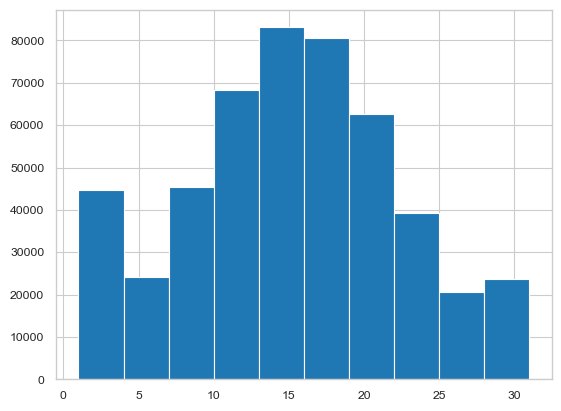

In [1401]:
dislok.groupby(['wagnum', 'plan_date', 'isload']).size().hist()

In [1402]:
load_sum = dislok.groupby(['wagnum', 'plan_date', 'isload']).size()

In [1407]:
load_sum = load_sum.to_frame().reset_index()

In [1412]:
load_sum.rename(columns={0:'days_load'}, inplace=True)

In [1417]:
load_sum = load_sum[load_sum['isload'] == 1]

In [1424]:
load_sum = load_sum.copy()

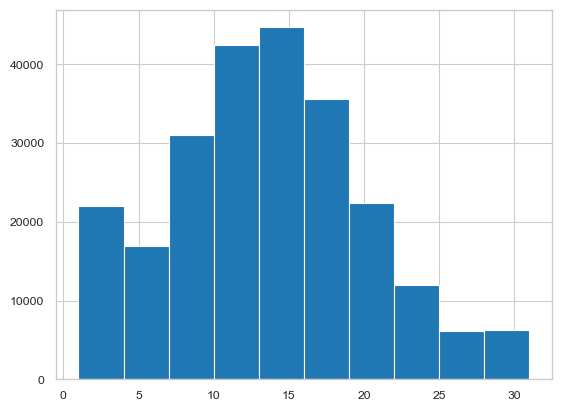

In [1421]:
load_sum['days_load'].hist()
plt.show()

<Axes: >

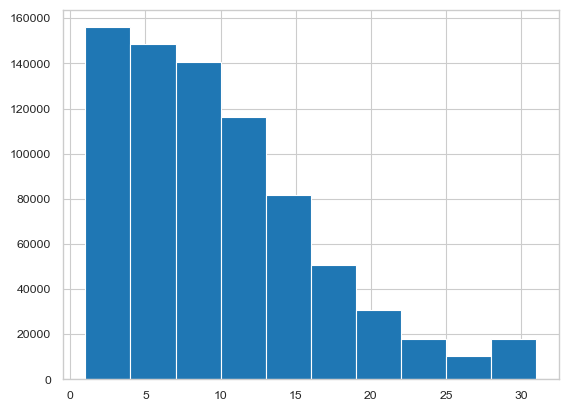

In [1427]:
dislok.groupby(['wagnum', 'plan_date', 'fr_id']).size().hist()

In [1431]:
fr_change = dislok.groupby(['wagnum', 'plan_date', 'fr_id']).size().to_frame().reset_index()

In [1437]:
fr_change = dislok.groupby(['wagnum', 'plan_date'])['fr_id'].unique()

In [1446]:
fr_change = fr_change.to_frame().reset_index()

In [1452]:
fr_change['fr_id'] = fr_change['fr_id'].apply(len)

TypeError: object of type 'int' has no len()

<Axes: >

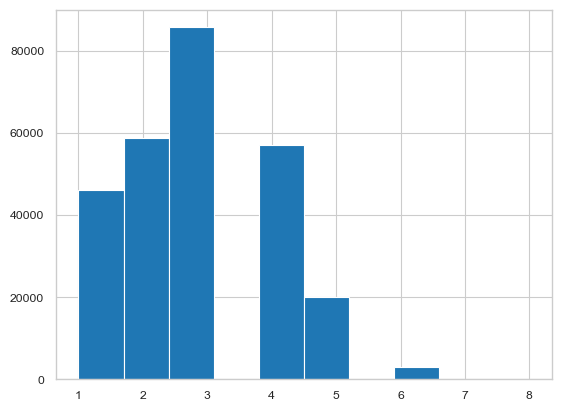

In [1454]:
fr_change['fr_id'].hist()

In [1455]:
fr_change.rename(columns={'fr_id':'fr_changes'}, inplace=True)

In [1513]:
dislok_last = dislok.drop_duplicates(subset = ['wagnum', 'plan_date'], keep = 'last')

In [1514]:
dislok_last.isna().sum()

plan_date            0
wagnum               0
date_kap        119826
date_dep         15304
kod_vrab             0
date_pl_rem          0
id_road_disl         0
st_id_dest           0
id_road_dest         0
st_id_send           0
id_road_send         0
ost_prob         10197
isload               0
fr_id                0
last_fr_id           0
distance             0
dtype: int64

In [1515]:
dislok_last.loc[:, 'date_kap'] = dislok_last.loc[:, 'date_kap'].astype('string')

In [1516]:
dislok_last.loc[:, 'date_kap'] = dislok_last.loc[:, 'date_kap'].fillna(0)

In [1517]:
dislok_last.loc[dislok_last['date_kap'] != 0, 'date_kap'] = 1

In [1518]:
dislok_last

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
30,2022-08-01,1071,0,2020-02-16,0,2023-02-16,42,11663,0,11470,42,33933,1,1204,1204,936
61,2022-08-01,1072,0,2019-12-29,0,2022-12-29,30,22,30,7602,30,157905,0,5032,430,-1
92,2022-08-01,834,0,2021-07-02,0,2024-07-02,43,12042,43,10074,38,106439,1,3250,3250,5006
123,2022-08-01,835,0,2020-09-19,0,2023-09-19,25,22,25,5906,28,85493,1,4987,4987,-1
154,2022-08-01,3205,0,NaT,0,2026-08-09,38,11464,42,8370,36,448949,1,545,545,3998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044800,2023-03-01,30358,0,2020-06-27,1,2023-06-27,16,22,16,4420,16,33717,0,620,620,-1
1044831,2023-03-01,21168,1,2017-11-21,0,2023-05-19,25,22,25,5840,25,156097,0,1982,1982,-1
1044862,2023-03-01,27006,1,2020-07-22,0,2023-07-22,38,10348,38,5281,25,145150,0,2255,1660,-1
1044893,2023-03-01,6135,1,2020-04-09,1,2023-04-09,43,22,43,11891,43,2373,0,5032,1475,896


In [1519]:
dislok_last.loc[:, 'date_dep'] = dislok_last.loc[:, 'date_dep'].astype('string')

In [1520]:
dislok_last.loc[:, 'date_dep'] = dislok_last.loc[:, 'date_dep'].fillna(0)

In [1521]:
dislok_last.loc[dislok_last['date_dep'] != 0, 'date_dep'] = 1

In [1522]:
dislok_last

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
30,2022-08-01,1071,0,1,0,2023-02-16,42,11663,0,11470,42,33933,1,1204,1204,936
61,2022-08-01,1072,0,1,0,2022-12-29,30,22,30,7602,30,157905,0,5032,430,-1
92,2022-08-01,834,0,1,0,2024-07-02,43,12042,43,10074,38,106439,1,3250,3250,5006
123,2022-08-01,835,0,1,0,2023-09-19,25,22,25,5906,28,85493,1,4987,4987,-1
154,2022-08-01,3205,0,0,0,2026-08-09,38,11464,42,8370,36,448949,1,545,545,3998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044800,2023-03-01,30358,0,1,1,2023-06-27,16,22,16,4420,16,33717,0,620,620,-1
1044831,2023-03-01,21168,1,1,0,2023-05-19,25,22,25,5840,25,156097,0,1982,1982,-1
1044862,2023-03-01,27006,1,1,0,2023-07-22,38,10348,38,5281,25,145150,0,2255,1660,-1
1044893,2023-03-01,6135,1,1,1,2023-04-09,43,22,43,11891,43,2373,0,5032,1475,896


In [1523]:
load_sum['wag_date'] = load_sum['wagnum'].astype('string')+(load_sum['plan_date'].astype('string'))


In [1524]:
dislok_last.loc[:, 'wag_date'] = dislok_last['wagnum'].astype('string')+(dislok_last['plan_date'].astype('string'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [1528]:
dislok_l = dislok_last.copy()

In [1529]:
dislok_l = dislok_l.merge(load[['wag_date', 'days_load']], how = 'left', on = 'wag_date')

In [1531]:
fr_change['wag_date'] = fr_change['wagnum'].astype('string')+(fr_change['plan_date'].astype('string'))

In [1532]:
dislok_l = dislok_l.merge(fr_change[['wag_date', 'fr_changes']], how = 'left', on = 'wag_date')

In [1534]:
dislok_l.isna().sum()

plan_date           0
wagnum              0
date_kap            0
date_dep            0
kod_vrab            0
date_pl_rem         0
id_road_disl        0
st_id_dest          0
id_road_dest        0
st_id_send          0
id_road_send        0
ost_prob        10197
isload              0
fr_id               0
last_fr_id          0
distance            0
wag_date            0
days_load       31657
fr_changes          0
dtype: int64

In [1535]:
dislok_l['ost_prob'] = dislok_l['ost_prob'].fillna(dislok_l['ost_prob'].median())

In [1536]:
dislok_l['days_load'].fillna(0, inplace=True)

In [1542]:
meta_wag_tr_rem['month'] = pd.to_datetime(meta_wag_tr_rem['month'])

In [1543]:
meta_wag_final = meta_wag_tr_rem.merge(dislok_l, how = 'left', left_on = ['wagnum', 'month'], right_on = ['wagnum', 'plan_date'])

In [1545]:
meta_wag_final.drop(columns=['wag_date'], inplace = True)

In [1549]:
meta_wag_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194622 entries, 0 to 194621
Data columns (total 61 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   wagnum              194622 non-null  Int64         
 1   ost_prob_x          194622 non-null  Int64         
 2   manage_type         194622 non-null  Int64         
 3   rod_id              194622 non-null  Int64         
 4   reestr_state        194622 non-null  Int64         
 5   target_month        194622 non-null  Int64         
 6   target_day          194622 non-null  Int64         
 7   prob_diff           194622 non-null  object        
 8   month               194622 non-null  datetime64[ns]
 9   model               194622 non-null  string        
 10  gruz                194622 non-null  Int64         
 11  cnsi_gruz_capacity  194622 non-null  Int64         
 12  cnsi_volumek        194622 non-null  Float64       
 13  tara                194622 no

In [1551]:
meta_wag_final.dropna(inplace = True)
meta_wag_final.reset_index(drop=True, inplace=True)

In [1553]:
meta_wag_final.to_csv('meta_wag_final.csv')

### Фичи для февраля

In [1558]:
dislok_feb = dislok_l[dislok_l['plan_date'] == '2023-02-01'].copy()

In [1559]:
dislok_feb.drop(columns=['plan_date'], inplace=True)

In [1560]:
wag_feb_tr_rem_dis = wag_feb_tr_rem.merge(dislok_feb, how='left', on='wagnum')

In [1565]:
wag_feb_tr_rem_dis['date_dep'].fillna(0, inplace=True)

In [1566]:
wag_feb_tr_rem_dis['date_kap'].fillna(0, inplace=True)

In [1570]:
wag_feb_tr_rem_dis.drop(columns=['wag_date'], inplace=True)

In [1571]:
wag_feb_tr_rem_dis.fillna(0, inplace=True)

In [1561]:
wag_feb_tr_rem_dis.isna().sum()

wagnum                0
ost_prob_x            0
manage_type           0
rod_id                0
reestr_state          0
prob_diff             0
gruz                  0
cnsi_gruz_capacity    0
cnsi_volumek          0
tara                  0
zavod_build           0
cnsi_probeg_dr        0
cnsi_probeg_kr        0
kuzov                 0
telega                0
tormoz                0
tipvozd               0
tippogl               0
norma_km              0
ownertype             0
lifespan              0
lefttime              0
kod_vrab_x            0
neis1_kod             0
neis2_kod             0
neis3_kod             0
mod1_kod              0
mod2_kod              0
mod3_kod              0
mod4_kod              0
mod5_kod              0
mod6_kod              0
mod7_kod              0
road_id_send          0
gr_probeg             0
por_probeg            0
st_id_send_x          0
rem_count             0
date_kap              7
date_dep              7
kod_vrab_y            7
date_pl_rem     

In [1573]:
wag_feb_tr_rem_dis.to_csv('feb_features.csv')

In [1608]:
#wag_feb_tr_rem_dis.drop(columns=['date_pl_rem'], inplace=True)

#wag_feb_tr_rem_dis.drop(columns=['plan_date'], inplace=True)

## Обучение на полной выборке для предикта за март

In [1575]:
meta_wag_param_f = meta_wag_final.copy()

meta_wag_param_f.drop(columns=['date_build', 'srok_sl', 'month', 'model'], inplace=True)
meta_wag_param_f.reset_index(drop=True, inplace=True)

meta_wag_param_f.columns

#meta_wag_param_f.to_csv('meta_wag_param_train_v2.csv')

Index(['wagnum', 'ost_prob_x', 'manage_type', 'rod_id', 'reestr_state',
       'target_month', 'target_day', 'prob_diff', 'gruz', 'cnsi_gruz_capacity',
       'cnsi_volumek', 'tara', 'zavod_build', 'cnsi_probeg_dr',
       'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz', 'tipvozd', 'tippogl',
       'norma_km', 'ownertype', 'lifespan', 'lefttime', 'kod_vrab_x',
       'neis1_kod', 'neis2_kod', 'neis3_kod', 'mod1_kod', 'mod2_kod',
       'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod', 'mod7_kod',
       'road_id_send', 'gr_probeg', 'por_probeg', 'st_id_send_x', 'rem_count',
       'plan_date', 'date_kap', 'date_dep', 'kod_vrab_y', 'date_pl_rem',
       'id_road_disl', 'st_id_dest', 'id_road_dest', 'st_id_send_y',
       'id_road_send', 'ost_prob_y', 'isload', 'fr_id', 'last_fr_id',
       'distance', 'days_load', 'fr_changes'],
      dtype='object')

In [1576]:
meta_wag_param_f.head(2)

,wagnum,ost_prob_x,manage_type,rod_id,reestr_state,target_month,target_day,prob_diff,gruz,cnsi_gruz_capacity,...,id_road_dest,st_id_send_y,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,days_load,fr_changes
0,0,52852,0,0,1,0,0,-4158,680,680,...,42,11448,42,52852,0,2255,3381,1279,5.0,2.0
1,1,93045,0,0,1,0,0,-24,680,680,...,44,12281,44,93045,0,2255,4987,-1,0.0,1.0


In [1594]:
meta_wag_param_f.drop(columns=['date_pl_rem'], inplace=True)

In [1588]:
meta_wag_param_f.drop(columns=['plan_date'], inplace=True)

In [1597]:
features = meta_wag_param_f.drop(columns=['target_month', 'target_day'])
target_m = meta_wag_param_f['target_month']
target_d = meta_wag_param_f['target_day']

In [ ]:
meta_wag_param_f

In [1598]:
cat_features = ['manage_type', 'rod_id', 'reestr_state', 'tipvozd', 'ownertype', 'zavod_build', 'kuzov', 'telega', 'tormoz', 'tipvozd',\
                'tippogl', 'wagnum', 'kod_vrab_x', 'neis1_kod', 'neis2_kod', 'neis3_kod',
       'mod1_kod', 'mod2_kod', 'mod3_kod', 'mod4_kod', 'mod5_kod', 'mod6_kod',
       'mod7_kod', 'road_id_send', 'st_id_send_x',
        'date_kap', 'date_dep', 'kod_vrab_y',
       'id_road_disl', 'st_id_dest', 'id_road_dest', 'st_id_send_y',
       'id_road_send', 'isload', 'fr_id', 'last_fr_id',
       'distance']

### Предсказание на месяц

In [1599]:
pool_train = Pool(features, label=target_m, cat_features=cat_features)

In [1600]:
params = {
    'iterations': [100],
    'custom_loss': ['F1'],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'depth': [3, 6, 9]
}

In [1601]:
model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')

In [1602]:
gs = model.grid_search(params, X=pool_train)

0:	loss: 0.1370714	best: 0.1370714 (0)	total: 9.47s	remaining: 1m 44s
1:	loss: 0.0661468	best: 0.0661468 (1)	total: 18.4s	remaining: 1m 32s
2:	loss: 0.0640846	best: 0.0640846 (2)	total: 27.6s	remaining: 1m 22s
3:	loss: 0.0629545	best: 0.0629545 (3)	total: 36.6s	remaining: 1m 13s
4:	loss: 0.1285762	best: 0.0629545 (3)	total: 48.1s	remaining: 1m 7s
5:	loss: 0.0622389	best: 0.0622389 (5)	total: 1m	remaining: 1m
6:	loss: 0.0610889	best: 0.0610889 (6)	total: 1m 13s	remaining: 52.2s
7:	loss: 0.0613109	best: 0.0610889 (6)	total: 1m 25s	remaining: 42.8s
8:	loss: 0.1238095	best: 0.0610889 (6)	total: 1m 41s	remaining: 33.9s
9:	loss: 0.0610381	best: 0.0610381 (9)	total: 1m 58s	remaining: 23.7s
10:	loss: 0.0615517	best: 0.0610381 (9)	total: 2m 17s	remaining: 12.5s
11:	loss: 0.0619971	best: 0.0610381 (9)	total: 2m 36s	remaining: 0us
Estimating final quality...


In [1603]:
gs['params']

{'depth': 9, 'iterations': 100, 'learning_rate': 0.1, 'custom_metric': 'F1'}

In [1604]:
model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=1000,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.1,
    depth=9,                    
    verbose=False,
    cat_features=cat_features)

In [1605]:
model.fit(features, target_m)

#### Февраль

In [1609]:
features_test = wag_feb_tr_rem_dis.copy()


In [1610]:
features_test.isna().sum()

wagnum                0
ost_prob_x            0
manage_type           0
rod_id                0
reestr_state          0
prob_diff             0
gruz                  0
cnsi_gruz_capacity    0
cnsi_volumek          0
tara                  0
zavod_build           0
cnsi_probeg_dr        0
cnsi_probeg_kr        0
kuzov                 0
telega                0
tormoz                0
tipvozd               0
tippogl               0
norma_km              0
ownertype             0
lifespan              0
lefttime              0
kod_vrab_x            0
neis1_kod             0
neis2_kod             0
neis3_kod             0
mod1_kod              0
mod2_kod              0
mod3_kod              0
mod4_kod              0
mod5_kod              0
mod6_kod              0
mod7_kod              0
road_id_send          0
gr_probeg             0
por_probeg            0
st_id_send_x          0
rem_count             0
date_kap              0
date_dep              0
kod_vrab_y            0
id_road_disl    

In [1611]:
pred = model.predict(features_test)

In [1612]:
features_test['pred'] = pred

In [1613]:
features_test.head()

,wagnum,ost_prob_x,manage_type,rod_id,reestr_state,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,st_id_send_y,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,days_load,fr_changes,pred
0,0,42468,0,0,1,-10230.0,680,680,122.0,244,...,11412,42,42468,1,1671,1671,-1,17.0,3.0,0
1,1,83116,0,0,1,-9929.0,680,680,120.0,220,...,4782,28,83116,0,2255,4987,-1,0.0,1.0,0
2,2,50236,0,0,1,-2886.0,680,680,122.0,252,...,10175,38,50236,0,5032,1052,-1,11.0,3.0,0
3,3,52596,0,0,1,-3344.0,680,680,120.0,220,...,9546,37,52596,0,2255,1413,4499,4.0,2.0,0
4,4,87594,0,0,1,-2626.0,680,680,120.0,235,...,8364,36,87594,0,2255,1061,-1,4.0,2.0,0


In [1614]:
sub = pd.read_csv(path_train + '/target/y_predict_submit_example.csv')

In [1615]:
sub.head()

,wagnum,month,target_month,target_day
0,33361,2023-03-01,1,1
1,33364,2023-03-01,1,1
2,33366,2023-03-01,1,1
3,33358,2023-03-01,1,1
4,33349,2023-03-01,1,1


In [1616]:
len(sub)

33707

In [1617]:
new_sub = sub.merge(features_test[['pred', 'wagnum']], how='left', on='wagnum')

In [1618]:
new_sub.head()

,wagnum,month,target_month,target_day,pred
0,33361,2023-03-01,1,1,0
1,33364,2023-03-01,1,1,0
2,33366,2023-03-01,1,1,0
3,33358,2023-03-01,1,1,0
4,33349,2023-03-01,1,1,0


In [1619]:
new_sub.isna().sum()

wagnum          0
month           0
target_month    0
target_day      0
pred            0
dtype: int64

In [1620]:
len(new_sub)

33707

### Предсказание на 10 дней 

In [1621]:
pool_train = Pool(features, label=target_d, cat_features=cat_features)

In [1623]:
params = {
    'iterations': [100],
    'custom_loss': ['F1'],
    'learning_rate': [0.1],
    'depth': [3, 6, 9]
}

In [1624]:
model = ctb.CatBoostClassifier(cat_features=cat_features, random_state=RS, \
                               loss_function='Logloss', logging_level='Silent')

In [1625]:
gs = model.grid_search(params, X=pool_train)

0:	loss: 0.0383426	best: 0.0383426 (0)	total: 6.74s	remaining: 13.5s
1:	loss: 0.0361514	best: 0.0361514 (1)	total: 16.2s	remaining: 8.09s
2:	loss: 0.0354446	best: 0.0354446 (2)	total: 29.5s	remaining: 0us
Estimating final quality...


In [1626]:
gs['params']

{'depth': 9, 'iterations': 100, 'learning_rate': 0.1, 'custom_metric': 'F1'}

In [1627]:
model = ctb.CatBoostClassifier(loss_function='Logloss',
    iterations=500,
    custom_loss=['F1'],
    random_seed= RS,
    learning_rate= 0.1,
    depth=9,                    
    verbose=False,
    cat_features=cat_features)

In [1628]:
model.fit(features, target_d)

In [1629]:
pred_day = model.predict(features_test)

In [1630]:
(pred_day > 0).sum()

390

In [1631]:
features_test['pred_day'] = pred_day

In [1632]:
features_test.head()

,wagnum,ost_prob_x,manage_type,rod_id,reestr_state,prob_diff,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,id_road_send,ost_prob_y,isload,fr_id,last_fr_id,distance,days_load,fr_changes,pred,pred_day
0,0,42468,0,0,1,-10230.0,680,680,122.0,244,...,42,42468,1,1671,1671,-1,17.0,3.0,0,0
1,1,83116,0,0,1,-9929.0,680,680,120.0,220,...,28,83116,0,2255,4987,-1,0.0,1.0,0,0
2,2,50236,0,0,1,-2886.0,680,680,122.0,252,...,38,50236,0,5032,1052,-1,11.0,3.0,0,0
3,3,52596,0,0,1,-3344.0,680,680,120.0,220,...,37,52596,0,2255,1413,4499,4.0,2.0,0,0
4,4,87594,0,0,1,-2626.0,680,680,120.0,235,...,36,87594,0,2255,1061,-1,4.0,2.0,0,0


In [1633]:
new_sub = sub.merge(features_test[['pred_day', 'wagnum', 'pred']], how='left', on='wagnum')

In [1634]:
new_sub.head()

,wagnum,month,target_month,target_day,pred_day,pred
0,33361,2023-03-01,1,1,0,0
1,33364,2023-03-01,1,1,0,0
2,33366,2023-03-01,1,1,0,0
3,33358,2023-03-01,1,1,0,0
4,33349,2023-03-01,1,1,0,0


In [1635]:
new_sub.drop(columns=['target_month', 'target_day'], inplace=True)

In [1636]:
new_sub = new_sub.rename(columns={"pred": "target_month"})

In [1637]:
new_sub = new_sub.rename(columns={"pred_day": "target_day"})

In [1638]:
new_sub

,wagnum,month,target_day,target_month
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [1639]:
submission = new_sub[['wagnum', 'month', 'target_month', 'target_day']].copy()

In [1640]:
submission.to_csv('submission_v3.csv')

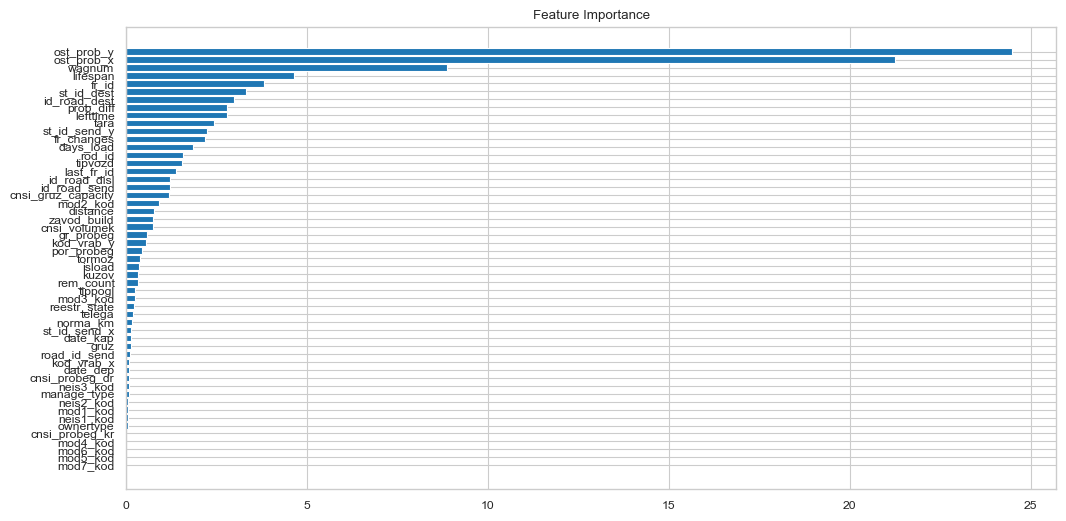

In [1645]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')

plt.show()